In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import aux.ts_functions as ts
import seaborn as sns; sns.set()
import numpy as np
import warnings
import os
from scipy.stats import pearsonr
from IPython.display import Image
import matplotlib
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse
import math
import glob
import re
from functools import reduce
from scipy.special import comb
from numpy.linalg import LinAlgError
from matplotlib.offsetbox import AnchoredText

data_dir = "./../data/"
imputed_data_dir = "./imputed_data/"

# Functions

## Loading

In [4]:
def get_ts(df, area, specie, toxin, resample_code, plot=True, show_df=False):
    if not isinstance(toxin, list):
        toxin = [toxin]
    ts = df[ (df["Production_Area"]==area) & (biotoxins_ts["Species"]==specie)]
    ts = ts.resample(resample_code).mean()
    if plot:
        fig, ax = plt.subplots(1,1, figsize=(14,7))
        ts.plot(ax=ax, marker='o', markersize=2)
    if show_df: 
        display(ts[toxin].head())
    return ts[toxin]

def get_ts_imputed(area, specie, toxin, suf, data_dir='/imputed_data', only_target=False):
    if suf == "areacorr":
        file_name = suf + '__' + area + '__' + toxin + '_' + specie
    elif suf == "speciecorr":
        file_name = suf + '__' + area + '_' + specie + '__' + toxin
    elif suf == "phytocorr":
        file_name = suf + '__' + area + '__' + toxin
    else:
        raise ValueError(f"Suffix {suf} is not valid.")
                    
    file = glob.glob(f'.{data_dir}/{file_name}*.csv')
    if len(file)>1:
        raise ValueError(f"Multiple files found when searching for '{file_name}'")
    elif len(file) == 0:
        raise FileNotFoundError(f"File '{file_name}' found")
    else:
        ts = pd.read_csv(file[0], index_col='Date', parse_dates=True)
        if only_target:
            if specie != None:
                return ts[[target + '_' + specie]]
            else:
                return ts[[target.replace('toxins','phyto')]]
        else:
            return ts



## Plot

In [5]:
for j in range(1):
    print(j)

0


In [6]:
def plot_corrs_ipma(df, min_corr, lags, area, type_corr="Pearson", k_range=range(2,21,2), target=None):
    n_cols = len(df.columns)
    
    if target != None:
        rows = [target]
        mult = 2
    else:
        rows = df.columns
        mult = 1
        
    columns = df.drop(columns=target).columns
        
    fig, axes = plt.subplots(len(rows), n_cols, figsize=(n_cols*2, len(rows)*mult), constrained_layout=True, sharey=True)
    if target != None: axes = axes.reshape(1,-1)
    
    fig.suptitle(area)
    for j in range(n_cols):
        for i in range(len(rows)):
            col1, col2 = rows[i], df.columns[j]
            if col1 == col2: continue
            ts1 = df[col1]
            ts2 = df[col2]
            
            ts = df[[col1,col2]].copy()
            df_corrs = pd.DataFrame({'lags' : lags, 'corrs': np.nan})
            
            highlight = False
            for lag in lags:
                temp = ts[col2].shift(lag)
                                
                if type_corr.lower() == 'pearson':
                    corr = ts[col1].corr(temp, method='pearson')
                else:
                    raise ValueError("Invalid type_corr")
                df_corrs.loc[df_corrs['lags'] == lag, 'corrs'] = corr
                if abs(corr) > min_corr:
                    highlight = True
                    
            a=i
            b=j
            sns.lineplot(data=df_corrs, x="lags", y="corrs", marker='o', markersize=4, ax=axes[a][b])
            axes[a][b].axvline(0, linestyle="--", color="r", linewidth=0.5)
            axes[a][b].axhline(0, linestyle="-", color="black", linewidth=0.5)
            if highlight:
                axes[a][b].spines['bottom'].set_color('green')
                axes[a][b].spines['top'].set_color('green')
                axes[a][b].spines['left'].set_color('green')
                axes[a][b].spines['right'].set_color('green')
            
    for j in range(n_cols):
        axes[0][j].set_title(df.columns[j], size="xx-small")
        for i in range(len(rows)):
            axes[i][0].set_ylabel(df.columns[i], size='xx-small')

            axes[i][j].tick_params(axis='both', labelsize="x-small")
            axes[i][j].set(xlabel=None, ylabel=None)
            axes[i][j].get_xaxis().set_visible(False)
            
    plt.savefig(f"./images/ipmacorr_{area}.png")
    plt.show()
    
    

def plot_dpcca_ipma(df, min_corr, lags, area, type_corr="dpcca", k_range=[4, 12]):
    n_cols = len(df.columns)
    fig, axes = plt.subplots(n_cols, n_cols, figsize=(n_cols*1, n_cols*1), constrained_layout=True, sharey=True)
    fig.suptitle(area)
    for j in range(n_cols):
        for i in range(j):
            col1, col2 = df.columns[i], df.columns[j]
            
            ts1 = df[col1]
            ts2 = df[col2]
            
            ts = df[[col1,col2]].copy()            
            
            df_corrs = pd.DataFrame(columns=["lags", "corrs",'n'])
            for n in k_range:
                df_corrs = df_corrs.append(pd.DataFrame({'lags':lags, 'corrs':np.nan, 'n':str(n)}),
                                          ignore_index=True)
            
            highlight = False
            for n in k_range:
                for lag in lags:
                    temp = df.copy()
                    temp[col1] = df[col1].shift(lag)

                    if type_corr.lower() == 'dpcca':
                        z = 3
                    elif type_corr.lower() == "dcca":
                        z = 2
                    else:
                        raise ValueError("Invalid type_corr")
                    corr = compute_dpcca_others(temp.dropna().values, n)[z][0][1]
                    
                    df_corrs.loc[(df_corrs['lags'] == lag) & (df_corrs['n']==str(n)), 'corrs'] = corr
                    if abs(corr) > min_corr:
                        highlight = True
                        
            a=i
            b=j
            sns.lineplot(data=df_corrs, x="lags", y="corrs", hue="n", marker='o', markersize=4, ax=axes[a][b])
            axes[a][b].axvline(0, linestyle="--", color="r", linewidth=0.5)
            axes[a][b].axhline(0, linestyle="-", color="black", linewidth=0.5)
            axes[a][b].legend(prop={'size': 6})
            if highlight:
                axes[a][b].spines['bottom'].set_color('green')
                axes[a][b].spines['top'].set_color('green')
                axes[a][b].spines['left'].set_color('green')
                axes[a][b].spines['right'].set_color('green')
            
    for j in range(n_cols):
        axes[0][j].set_title(df.columns[j], size="xx-small")
        for i in range(n_cols):
            axes[i][0].set_ylabel(df.columns[i], size='xx-small')

            axes[i][j].tick_params(axis='both', labelsize="x-small")
            axes[i][j].set(xlabel=None, ylabel=None)
            axes[i][j].get_xaxis().set_visible(False)
            
    plt.savefig(f"./images/ipmacorr_dpcca_{area}.png")
    plt.show()



## DPCCA

In [7]:
# Return sliding windows
def sliding_window(xx,k):
    # Function to generate boxes given dataset(xx) and box size (k)
    import numpy as np

    # generate indexes! O(1) way of doing it :)
    idx = np.arange(k)[None, :]+np.arange(len(xx)-k+1)[:, None]
    return xx[idx],idx

def compute_dpcca_others(cdata,k):
    # Input: cdata(nsamples,nvars), k: time scale for dpcca
    # Output: dcca, dpcca, corr, partialCorr
    #
    # Date(last modification): 02/15/2018
    # Author: Jaime Ide (jaime.ide@yale.edu)
    
    # Code distributed "as is", in the hope that it will be useful, but WITHOUT ANY WARRANTY;
    # without even the implied warranty of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. 
    # See the GNU General Public License for more details.
    
    import numpy as np
    from numpy.matlib import repmat
    
    
    # Define
    nsamples,nvars = cdata.shape

    # Cummulative sum after removing mean
    #cdata = signal.detrend(cdata,axis=0) # different from only removing the mean...
    cdata = cdata-cdata.mean(axis=0)
    xx = np.cumsum(cdata,axis=0)
    
    F2_dfa_x = np.zeros(nvars)
    allxdif = []
    # Get alldif and F2_dfa
    for ivar in range(nvars): # do for all vars
        xx_swin , idx = sliding_window(xx[:,ivar],k)
        nwin = xx_swin.shape[0]
        b1, b0 = np.polyfit(np.arange(k),xx_swin.T,deg=1) # linear fit (UPDATE if needed)
        
        #x_hat = [[b1[i]*j+b0[i] for j in range(k)] for i in range(nwin)] # Slower version
        x_hatx = repmat(b1,k,1).T*repmat(range(k),nwin,1) + repmat(b0,k,1).T
    
        # Store differences to the linear fit
        xdif = xx_swin-x_hatx
        allxdif.append(xdif)
        # Eq.4
        F2_dfa_x[ivar] = (xdif**2).mean()
    # Get the DCCA matrix
    dcca = np.zeros([nvars,nvars])
    for i in range(nvars): # do for all vars
        for j in range(nvars): # do for all vars
            # Eq.5 and 6
            F2_dcca = (allxdif[i]*allxdif[j]).mean()
            # Eq.1: DCCA
            dcca[i,j] = F2_dcca / np.sqrt(F2_dfa_x[i] * F2_dfa_x[j])   
    
    # Get DPCCA
    C = np.linalg.inv(dcca)
    
    # (Clear but slow version)
    #dpcca = np.zeros([nvars,nvars])
    #for i in range(nvars):
    #    for j in range(nvars):
    #        dpcca[i,j] = -C[i,j]/np.sqrt(C[i,i]*C[j,j])
    
    # DPCCA (oneliner version)
    mydiag = np.sqrt(np.abs(np.diag(C)))
    dpcca = (-C/repmat(mydiag,nvars,1).T)/repmat(mydiag,nvars,1)+2*np.eye(nvars)
    
    # Include correlation and partial corr just for comparison ;)
    # Compute Corr
    corr = np.corrcoef(cdata.T)
    # Get parCorr
    cov = np.cov(cdata.T)
    C0 = np.linalg.inv(cov)
    mydiag = np.sqrt(np.abs(np.diag(C0)))
    parCorr = (-C0/repmat(mydiag,nvars,1).T)/repmat(mydiag,nvars,1)+2*np.eye(nvars)

    return corr,parCorr,dcca,dpcca

def get_k_for_dpcca(df, k_range, lags, type_corr):
    col1, col2 = df.columns
    corrs_per_k = {}
    for k in k_range:
        max_corr = 0
        for lag in lags:
            df[col1] = df[col1].shift(lag)
            try: 
                if type_corr.lower() == 'dpcca':
                    corr = compute_dpcca_others(df.dropna().values, k)[3][0][1]
                elif type_corr.lower() == 'dcca':
                    corr = compute_dpcca_others(df.dropna().values, k)[2][0][1]
                else:
                    raise ValueError("Invalid type_corr")
            except LinAlgError:
                print("LinAlgError for k = ", k)
                continue
                
            if abs(corr) > max_corr:
                max_corr = abs(corr)
        corrs_per_k[k] = max_corr
    return max(corrs_per_k, key=corrs_per_k.get)


# Loading

In [8]:
files = glob.glob(f"{imputed_data_dir}ipmacorr__*.csv")

dataframes = {}
for f in files:
    area = re.findall(r"ipmacorr__(.*).csv",f)[0]
    dataframes[area] = pd.read_csv(f"{imputed_data_dir}ipmacorr__{area}.csv",index_col='Date',parse_dates=True)
print(len(dataframes))
dataframes["L5b"].head()

9


,dsp_toxins,dsp_phyto,mean_sst,mean_chl,mean_temp,max_temp,min_temp,mean_wind_intensity,wind_dir,rainfall
Date,,,,,,,,,,
2015-01-11,36.0,20.0,287.512360,3.185552,8.142857,14.328571,3.157143,3.042857,1.285714,0.014286
2015-01-18,38.0,20.0,287.207123,2.522946,10.414286,15.328571,4.728571,2.400000,3.142857,7.557143
2015-01-25,36.0,20.0,286.799042,1.456212,9.885714,15.528571,3.914286,2.457143,6.000000,1.242857
2015-02-01,25.0,20.0,286.739044,1.855206,10.385714,16.314286,4.828571,2.571429,5.571429,0.971429
2015-02-08,23.0,20.0,286.095703,1.628662,8.557143,13.800000,2.642857,3.042857,4.714286,0.600000


## for dataset image

In [9]:
cols = []
for a in dataframes:
    cols += dataframes[a].columns.tolist()

cols = set(cols + ["production_area"])
dt = pd.DataFrame(columns=cols)

for a in dataframes:
    dt2 = dataframes[a]
    dt2["production_area"] = a
    dt = dt.append(dt2)
    
dt.drop(columns=["dsp_toxins", "dsp_phyto"]).sample(5)

,mean_wind_intensity,mean_chl,production_area,mean_wind_dir,mean_sst,rainfall,wind_dir,max_temp,mean_temp,min_temp
2020-04-26,NaN,2.548986,POR2,NaN,289.443542,2.442857,NaN,19.642857,14.800000,9.828571
2019-11-24,4.185714,0.810591,L7c1,225.000000,287.952850,2.042857,NaN,17.971429,14.285714,8.957143
2020-10-04,3.428571,2.559914,RIAV1,266.571429,290.931427,1.857143,5.857143,20.157143,16.442857,12.857143
2017-06-18,3.438114,6.433846,ETJ1,211.388921,292.114756,1.574548,5.664712,27.704762,20.711429,16.462857
2015-02-01,1.042857,1.208999,LAG,NaN,287.813812,1.085714,5.285714,15.942857,9.885714,4.057143


# Pearson

## All variables

In [10]:
#min_corr = 0.5
#lags = np.arange(-10, 11, 1)
#for area in dataframes:
#    ts = dataframes[area].drop(columns=["production_area"])
#    plot_corrs_ipma(ts.copy(), min_corr, lags, area=area, type_corr="Pearson", k_range=range(2,21,2))

## Toxin vs others

In [18]:
def plot_corrs_ipma_target(df,cols,min_corr, lags, area, type_corr="Pearson", k_range=range(2,21,2), target=None):
   
        
    fig, axes = plt.subplots(1, len(cols), figsize=(len(cols)*2, 2), constrained_layout=True, sharey=True)
    fig.suptitle(area)
    to_print=False
    for j in range(len(cols)):
        col = cols[j]
        if col not in df.columns:
            continue

        ts = df[[target,col]].copy()
        df_corrs = pd.DataFrame({'lags' : lags, 'corrs': np.nan})
        #display(ts)

        highlight = False
        for lag in lags:
            temp = ts[col].shift(lag)
            #display(temp)
            if type_corr.lower() == 'pearson':
                corr = ts[target].corr(temp, method='pearson')
            else:
                raise ValueError("Invalid type_corr")
            df_corrs.loc[df_corrs['lags'] == lag, 'corrs'] = corr
            if abs(corr) > min_corr:
                highlight = True
                to_print=True

        sns.lineplot(data=df_corrs, x="lags", y="corrs", marker='o', markersize=4, ax=axes[j])
        axes[j].axvline(0, linestyle="--", color="r", linewidth=0.5)
        axes[j].axhline(0, linestyle="-", color="black", linewidth=0.5)
        if highlight:
            axes[j].spines['bottom'].set_color('green')
            axes[j].spines['top'].set_color('green')
            axes[j].spines['left'].set_color('green')
            axes[j].spines['right'].set_color('green')

    for j in range(len(cols)):
        axes[j].set_title(cols[j], size="xx-small")
        
        axes[j].set_ylabel("corrs", size='xx-small')

        axes[j].tick_params(axis='both', labelsize="x-small")
        axes[j].set(xlabel=None)
        #axes[j].get_xaxis().set_visible(False)
    
    plt.savefig(f"./images/ipmacorr_{area}.png")
    if to_print:
        plt.show()
    else:
        plt.clf()
        plt.close()
    return 0
    

In [19]:
dataframes["L5b"].columns

Index(['dsp_toxins', 'dsp_phyto', 'mean_sst', 'mean_chl', 'mean_temp',
       'max_temp', 'min_temp', 'mean_wind_intensity', 'wind_dir', 'rainfall',
       'production_area'],
      dtype='object')

In [21]:
dataframes["L5b"].head()

,dsp_toxins,dsp_phyto,mean_sst,mean_chl,mean_temp,max_temp,min_temp,mean_wind_intensity,wind_dir,rainfall,production_area
Date,,,,,,,,,,,
2015-01-11,36.0,20.0,287.512360,3.185552,8.142857,14.328571,3.157143,3.042857,1.285714,0.014286,L5b
2015-01-18,38.0,20.0,287.207123,2.522946,10.414286,15.328571,4.728571,2.400000,3.142857,7.557143,L5b
2015-01-25,36.0,20.0,286.799042,1.456212,9.885714,15.528571,3.914286,2.457143,6.000000,1.242857,L5b
2015-02-01,25.0,20.0,286.739044,1.855206,10.385714,16.314286,4.828571,2.571429,5.571429,0.971429,L5b
2015-02-08,23.0,20.0,286.095703,1.628662,8.557143,13.800000,2.642857,3.042857,4.714286,0.600000,L5b


DSP Toxins

(O que move são as meteorologicas)

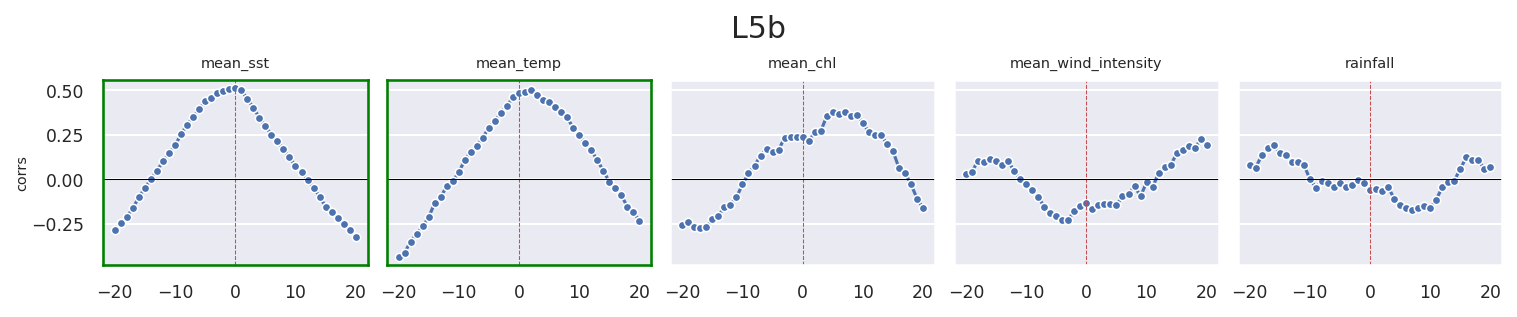

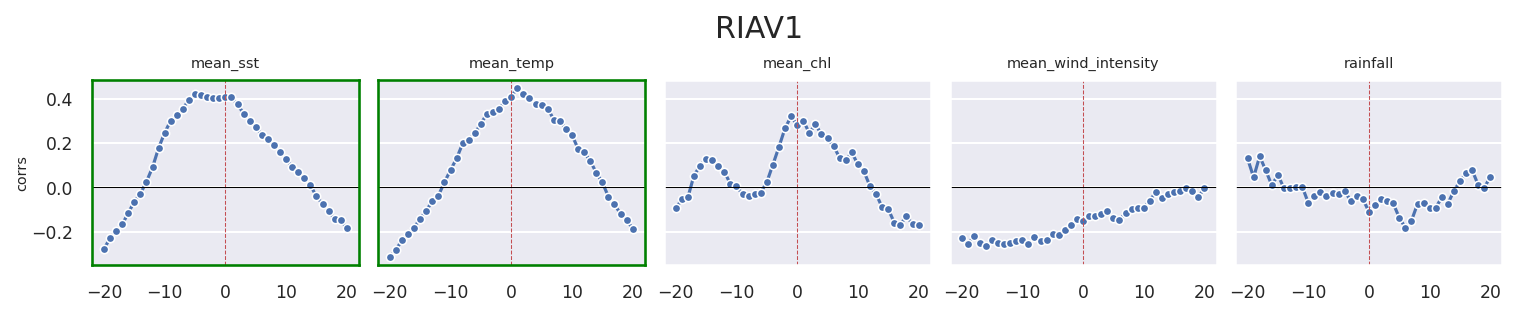

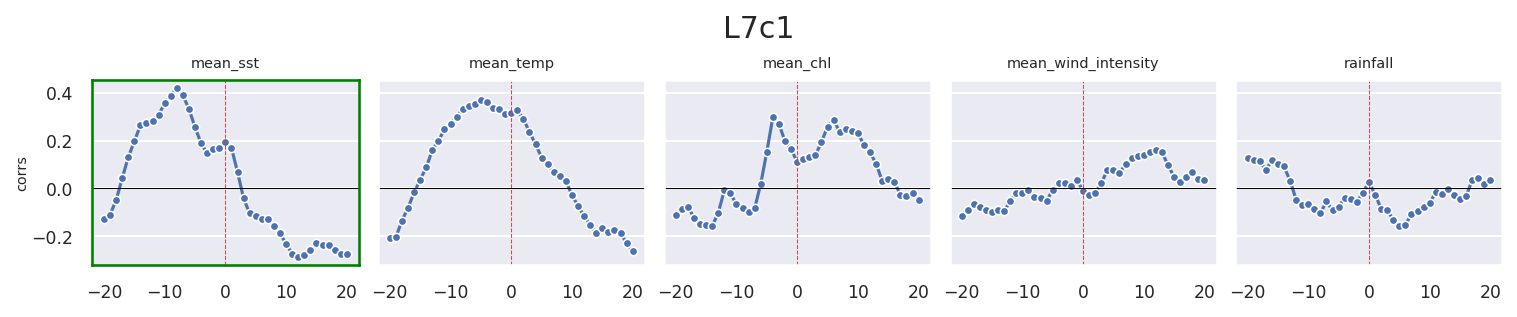

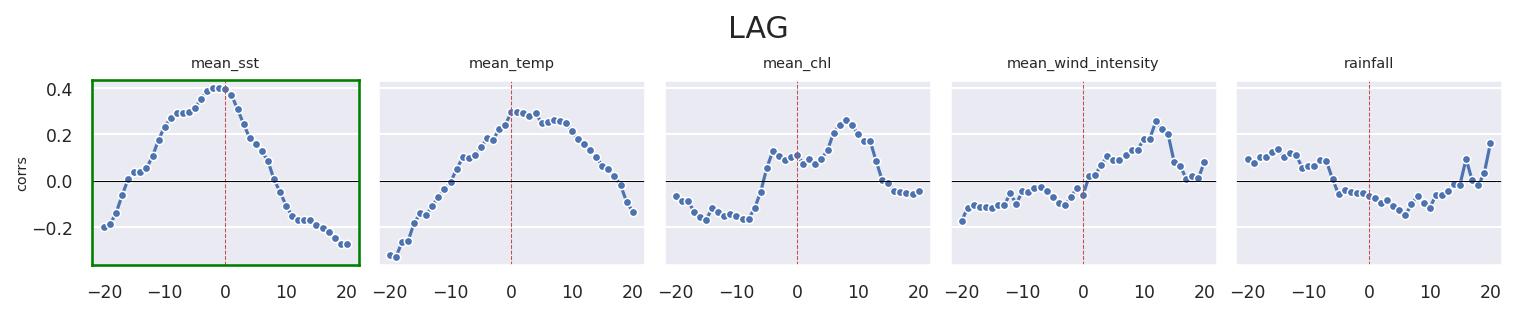

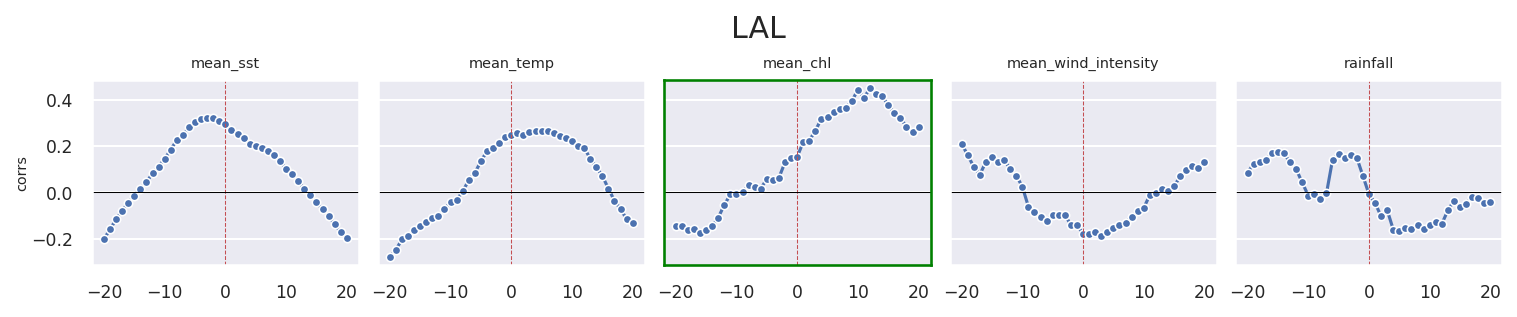

In [20]:
min_corr = 0.4
lags = np.arange(-20, 21, 1)
for area in dataframes:
    ts = dataframes[area]
    cols = ["mean_sst", "mean_temp", "mean_chl","mean_wind_intensity","rainfall"]
    plot_corrs_ipma_target(ts.copy(), cols, min_corr, lags, area=area, type_corr="Pearson", target="dsp_toxins")

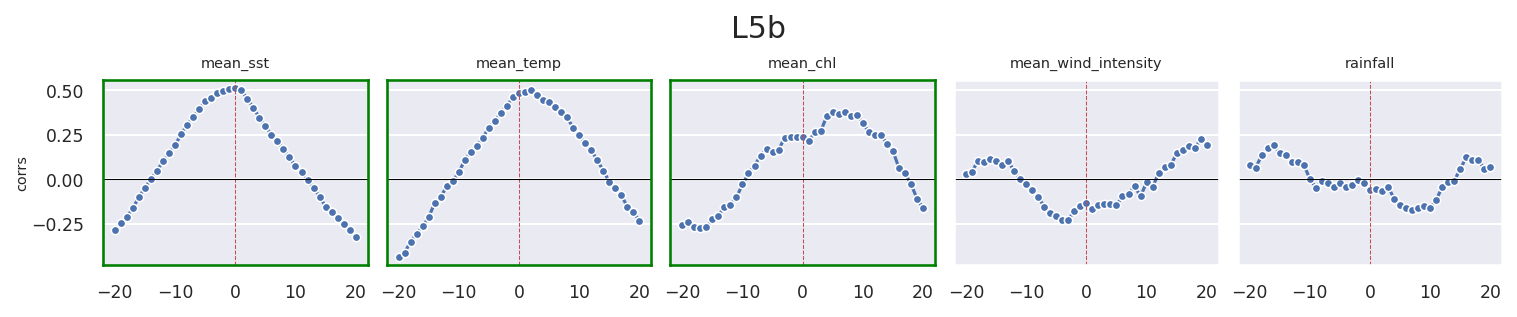

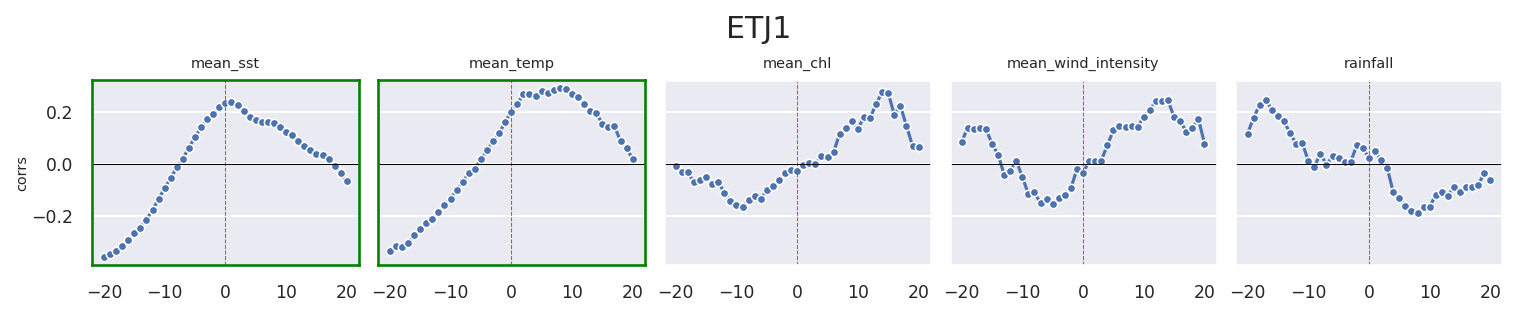

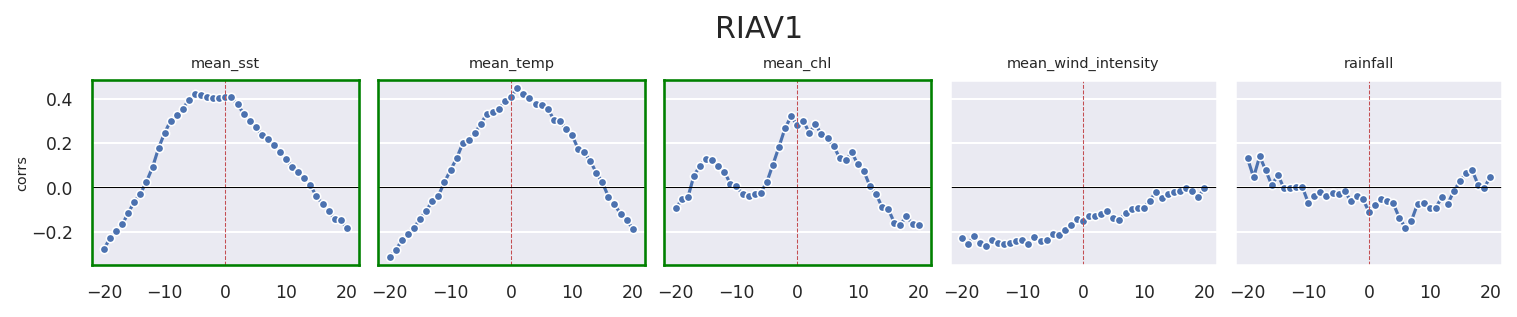

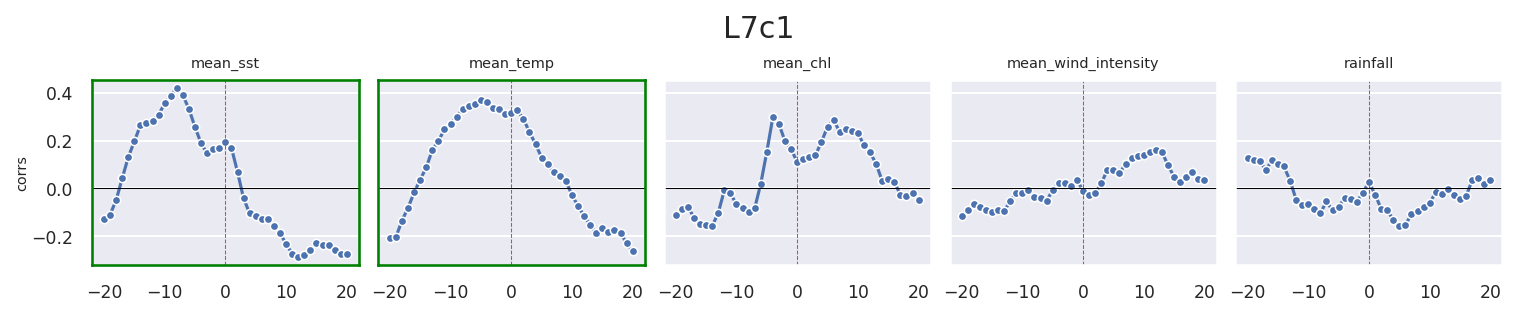

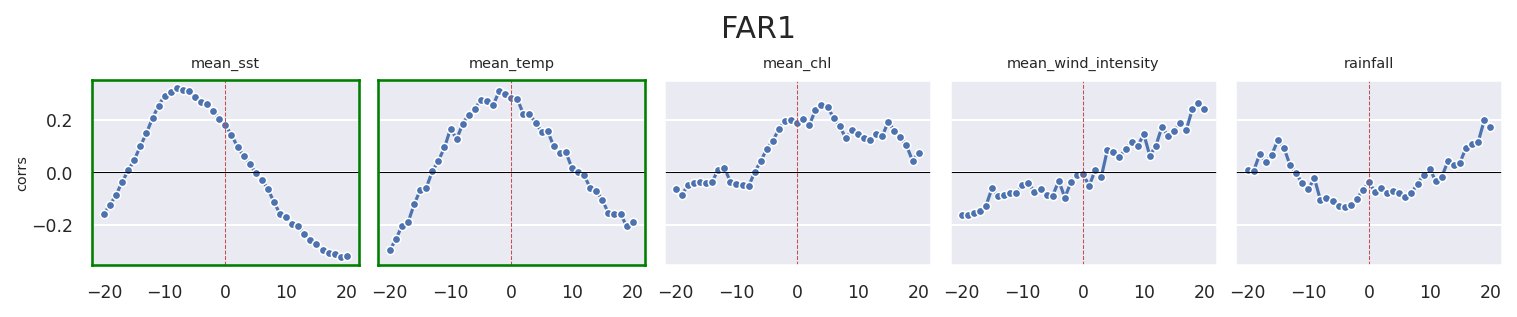

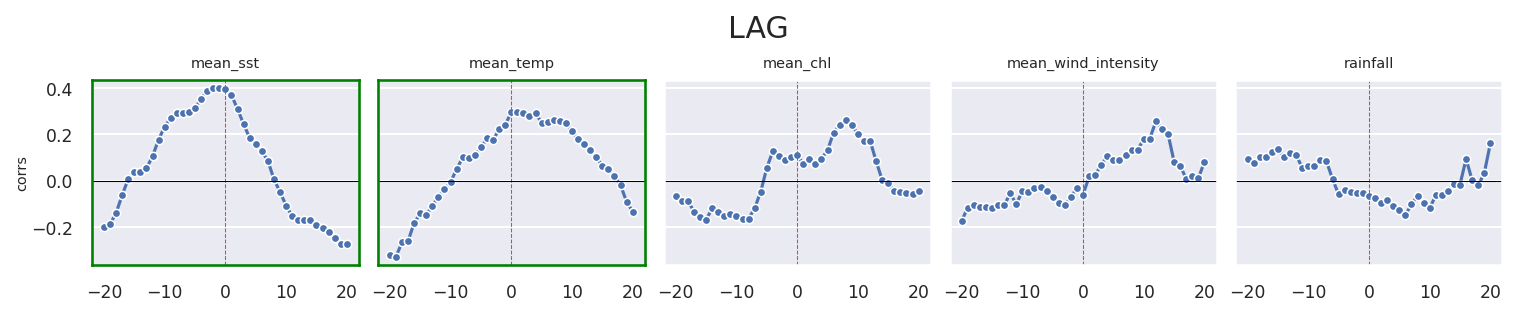

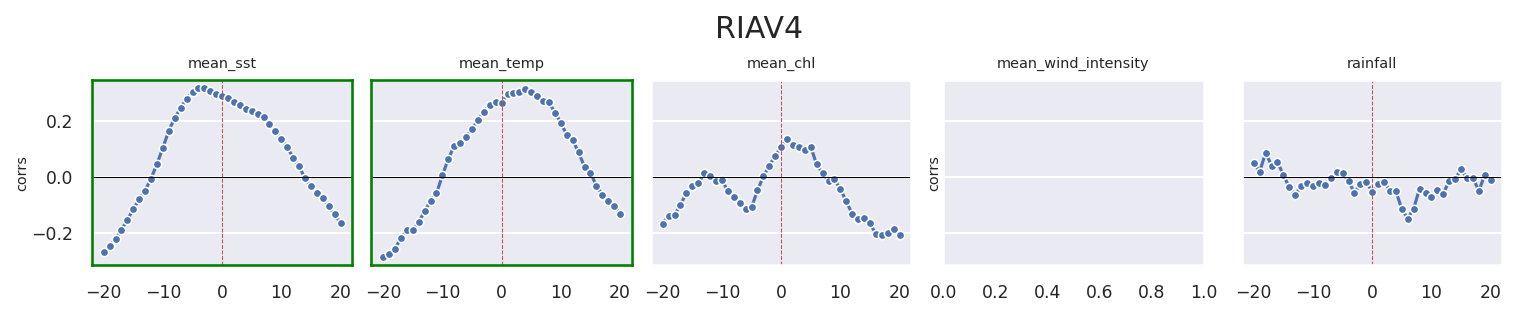

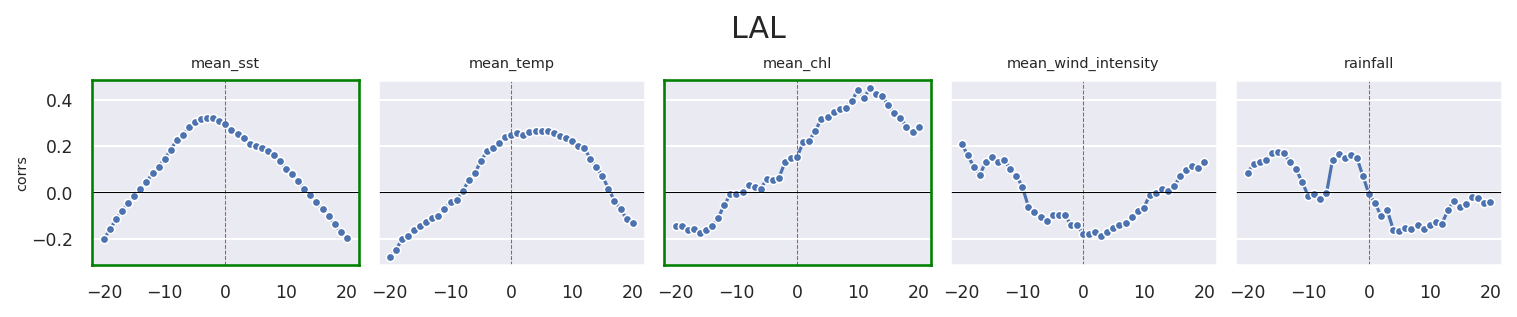

In [97]:
min_corr = 0.3
lags = np.arange(-20, 21, 1)
for area in dataframes:
    ts = dataframes[area]
    cols = ["mean_sst", "mean_temp", "mean_chl","mean_wind_intensity","rainfall"]
    plot_corrs_ipma_target(ts.copy(), cols, min_corr, lags, area=area, type_corr="Pearson", target="dsp_toxins")

DSP Phytoplankton

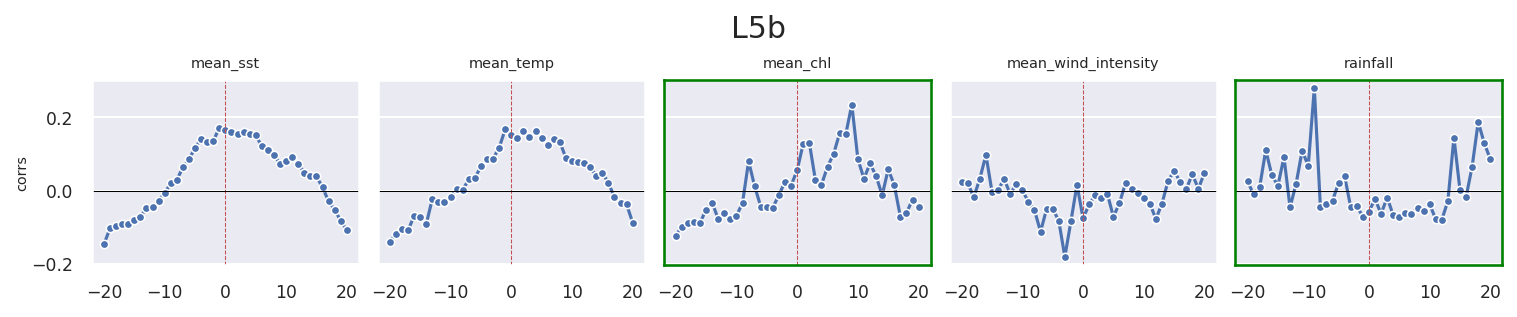

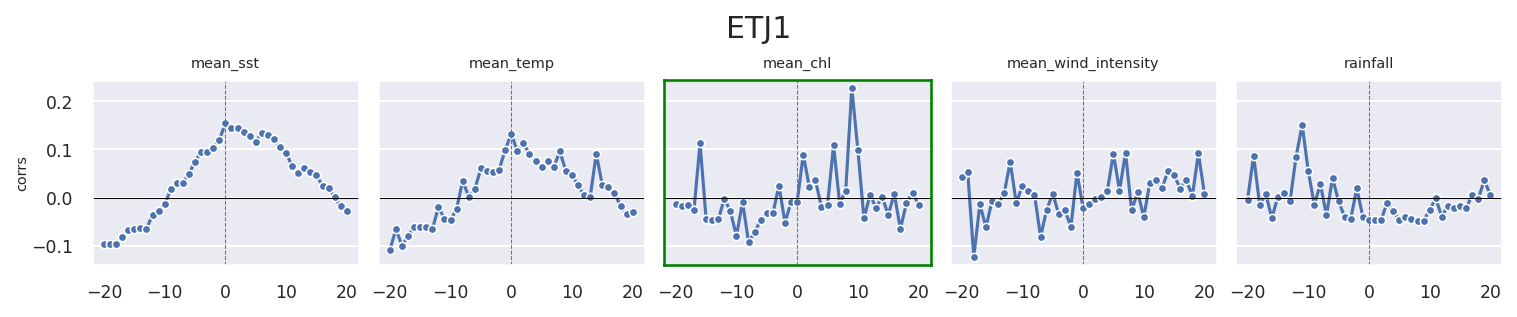

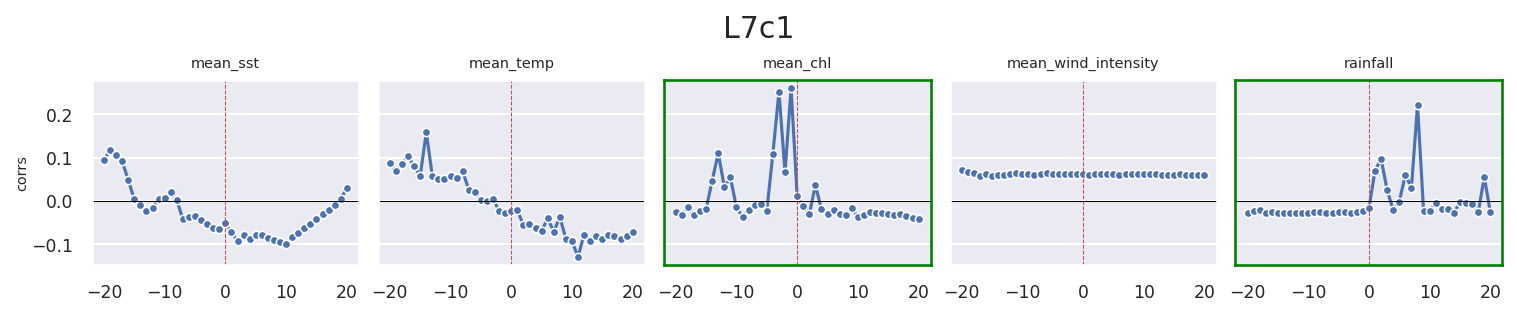

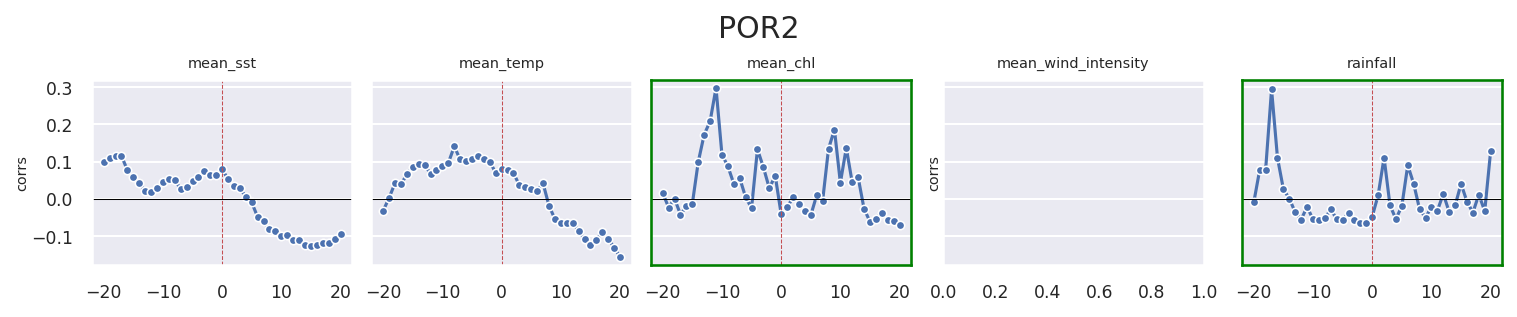

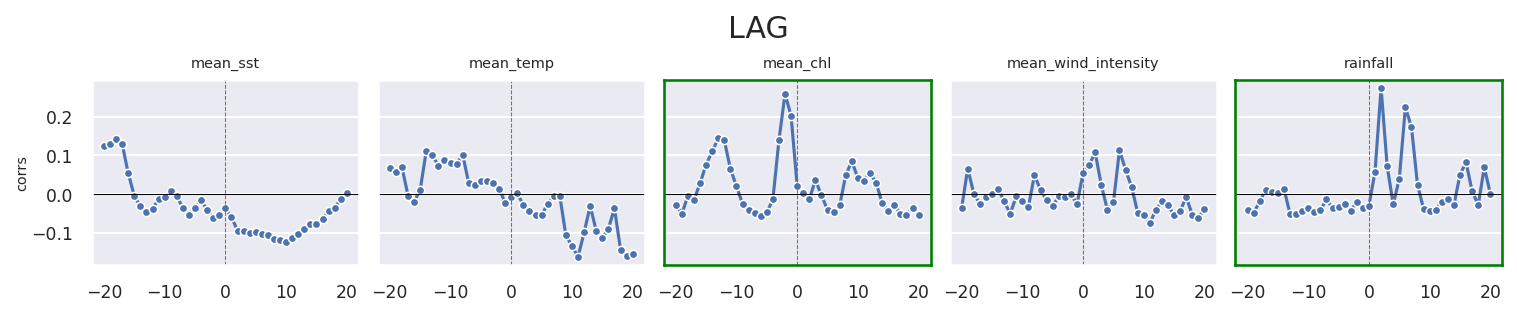

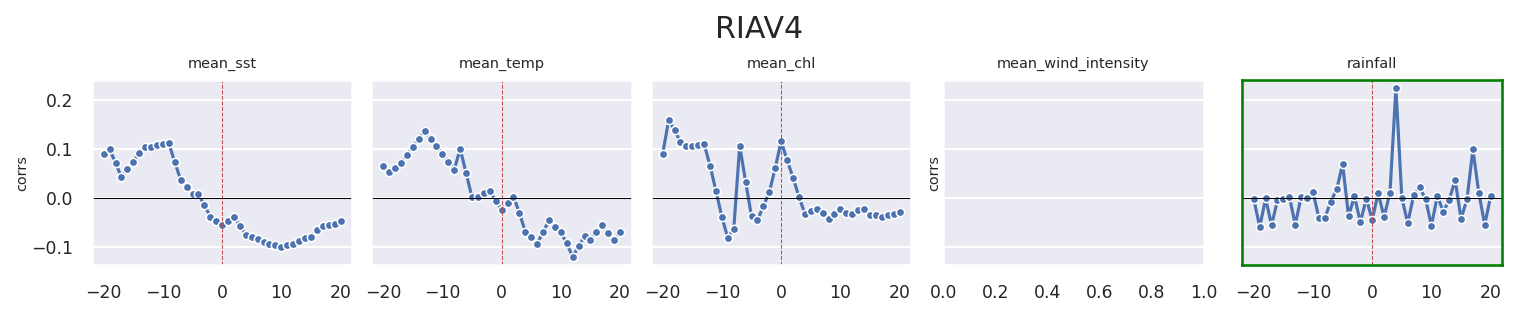

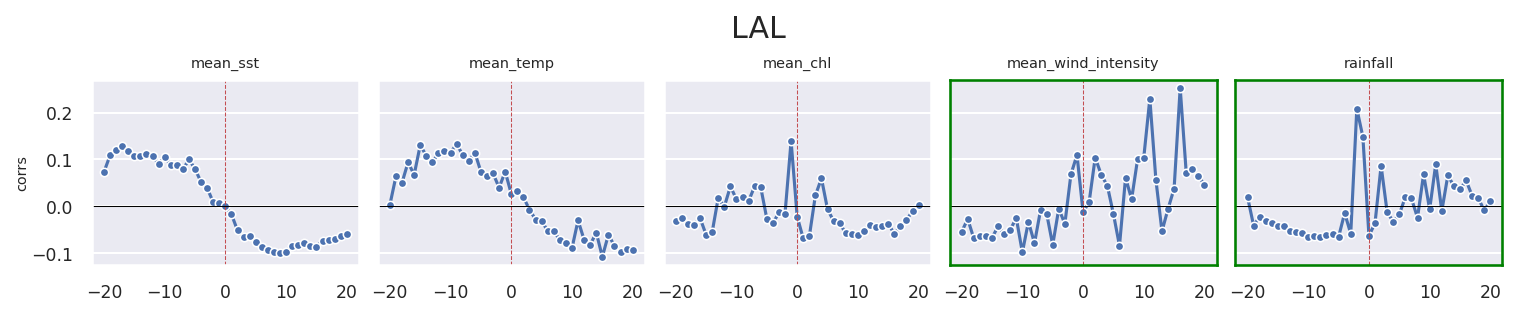

In [96]:
min_corr = 0.2
lags = np.arange(-20, 21, 1)
for area in dataframes:
    ts = dataframes[area]
    cols = ["mean_sst", "mean_temp", "mean_chl","mean_wind_intensity","rainfall"]
    plot_corrs_ipma_target(ts.copy(), cols, min_corr, lags, area=area, type_corr="Pearson", target="dsp_phyto")

# DPCCA

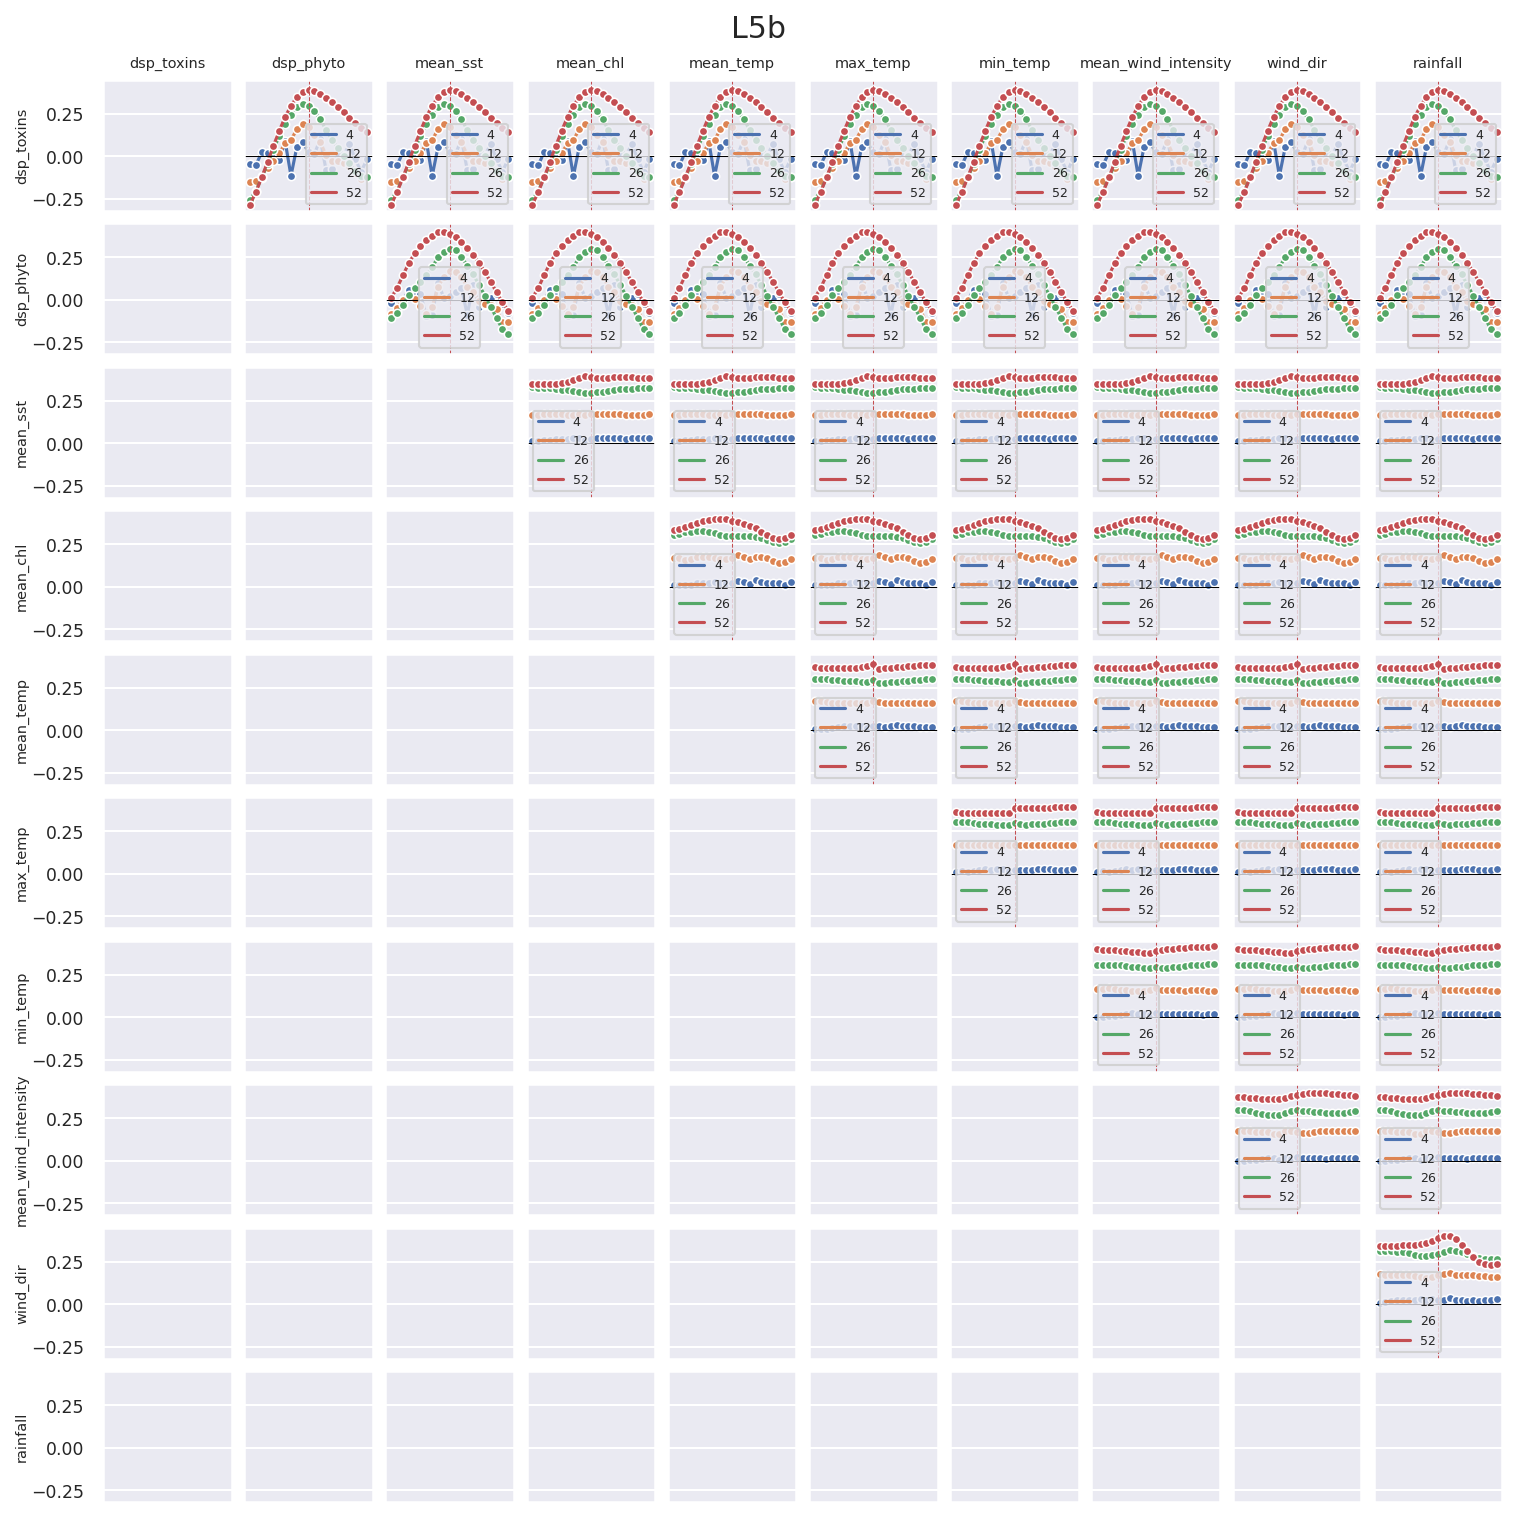

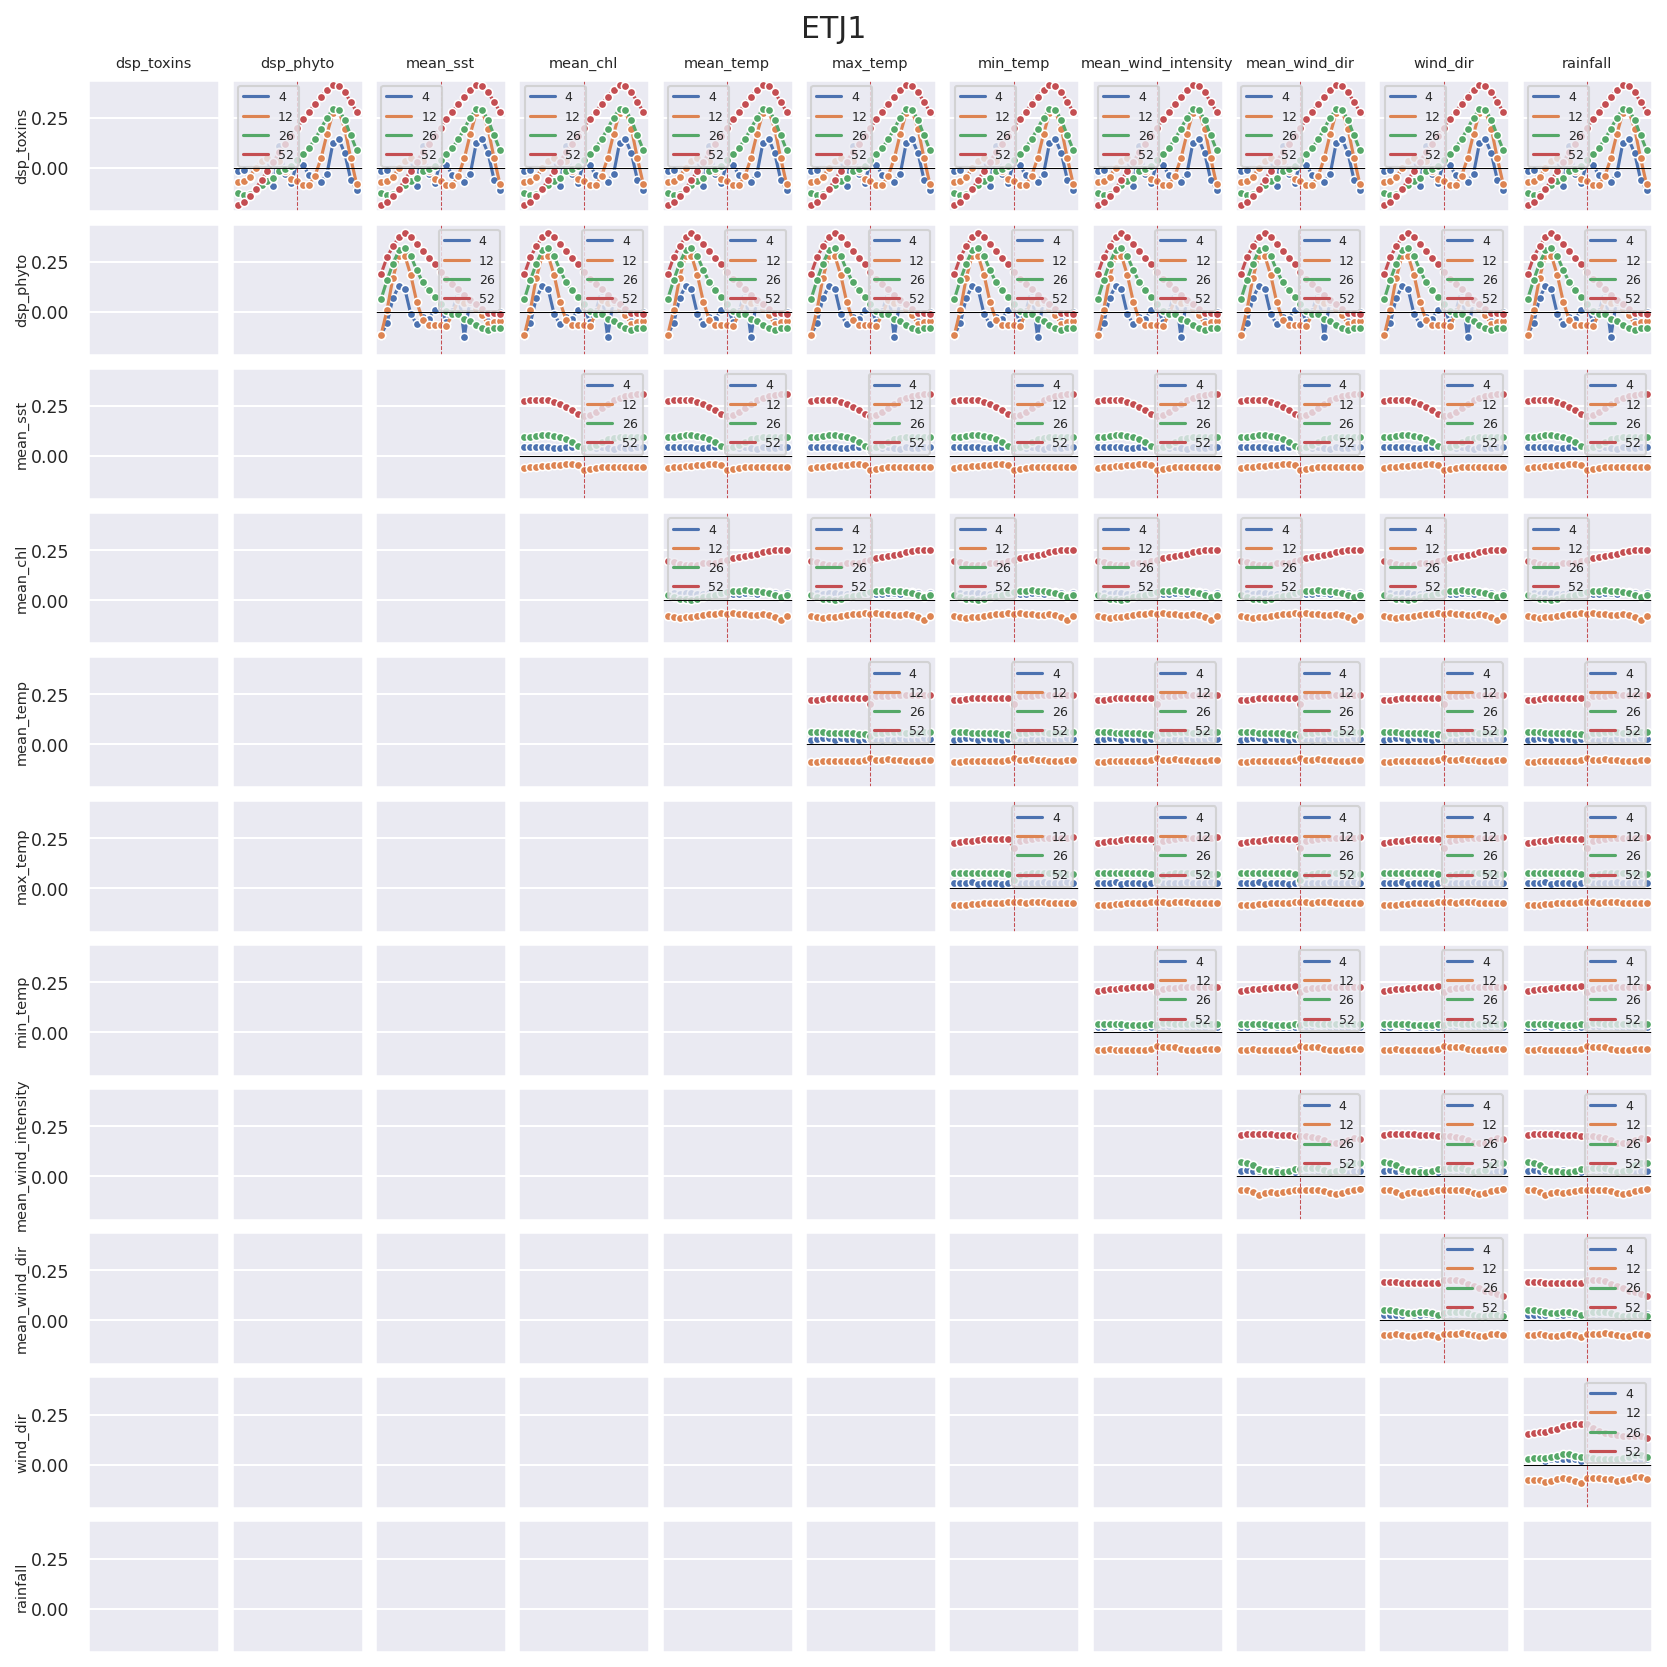

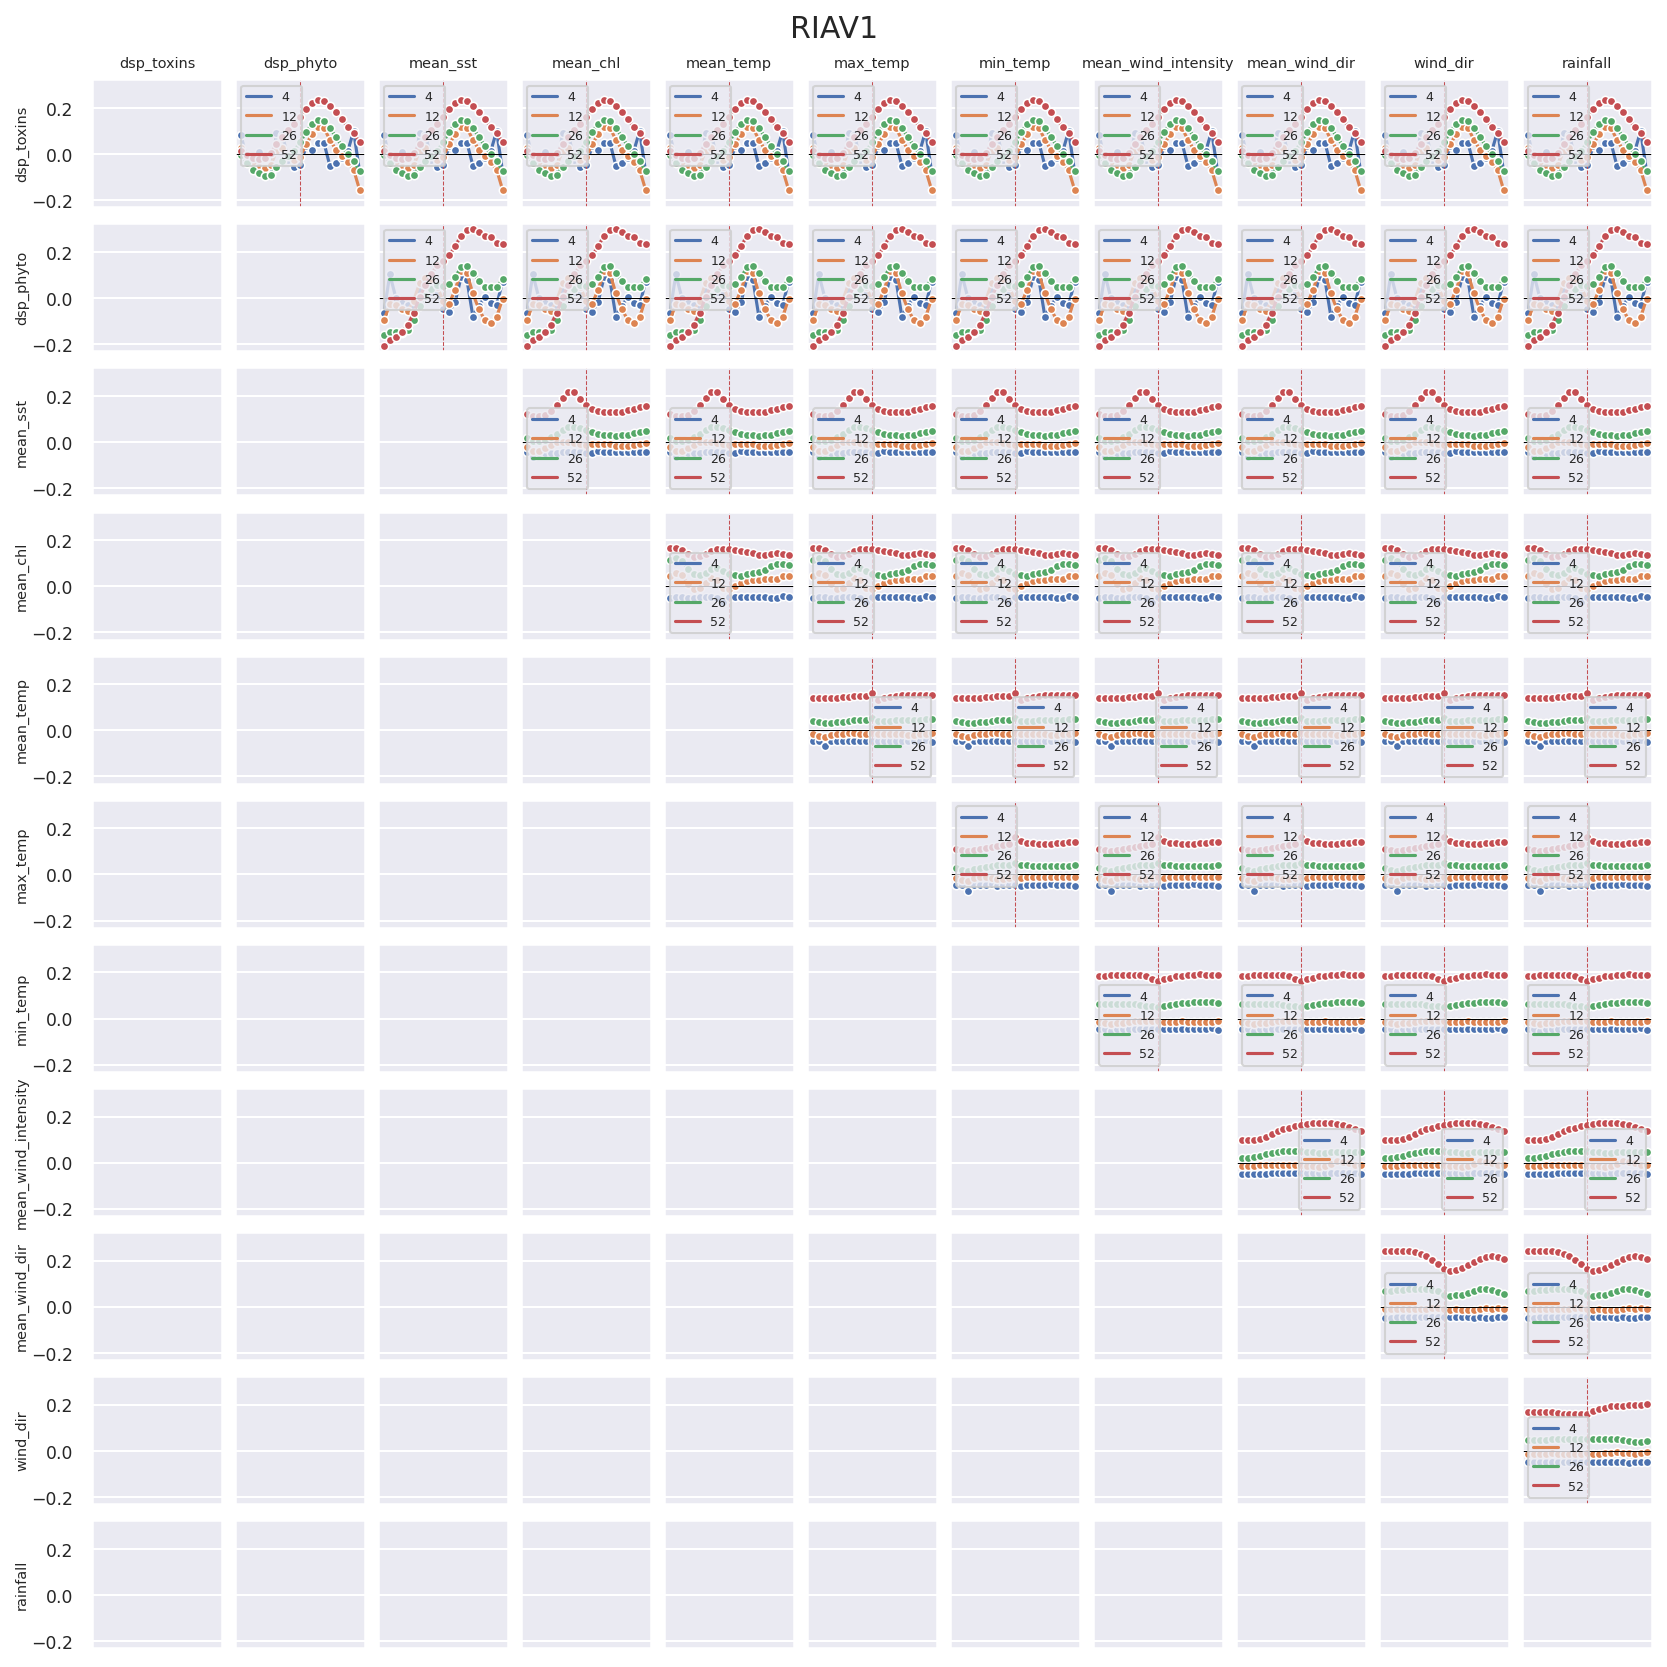

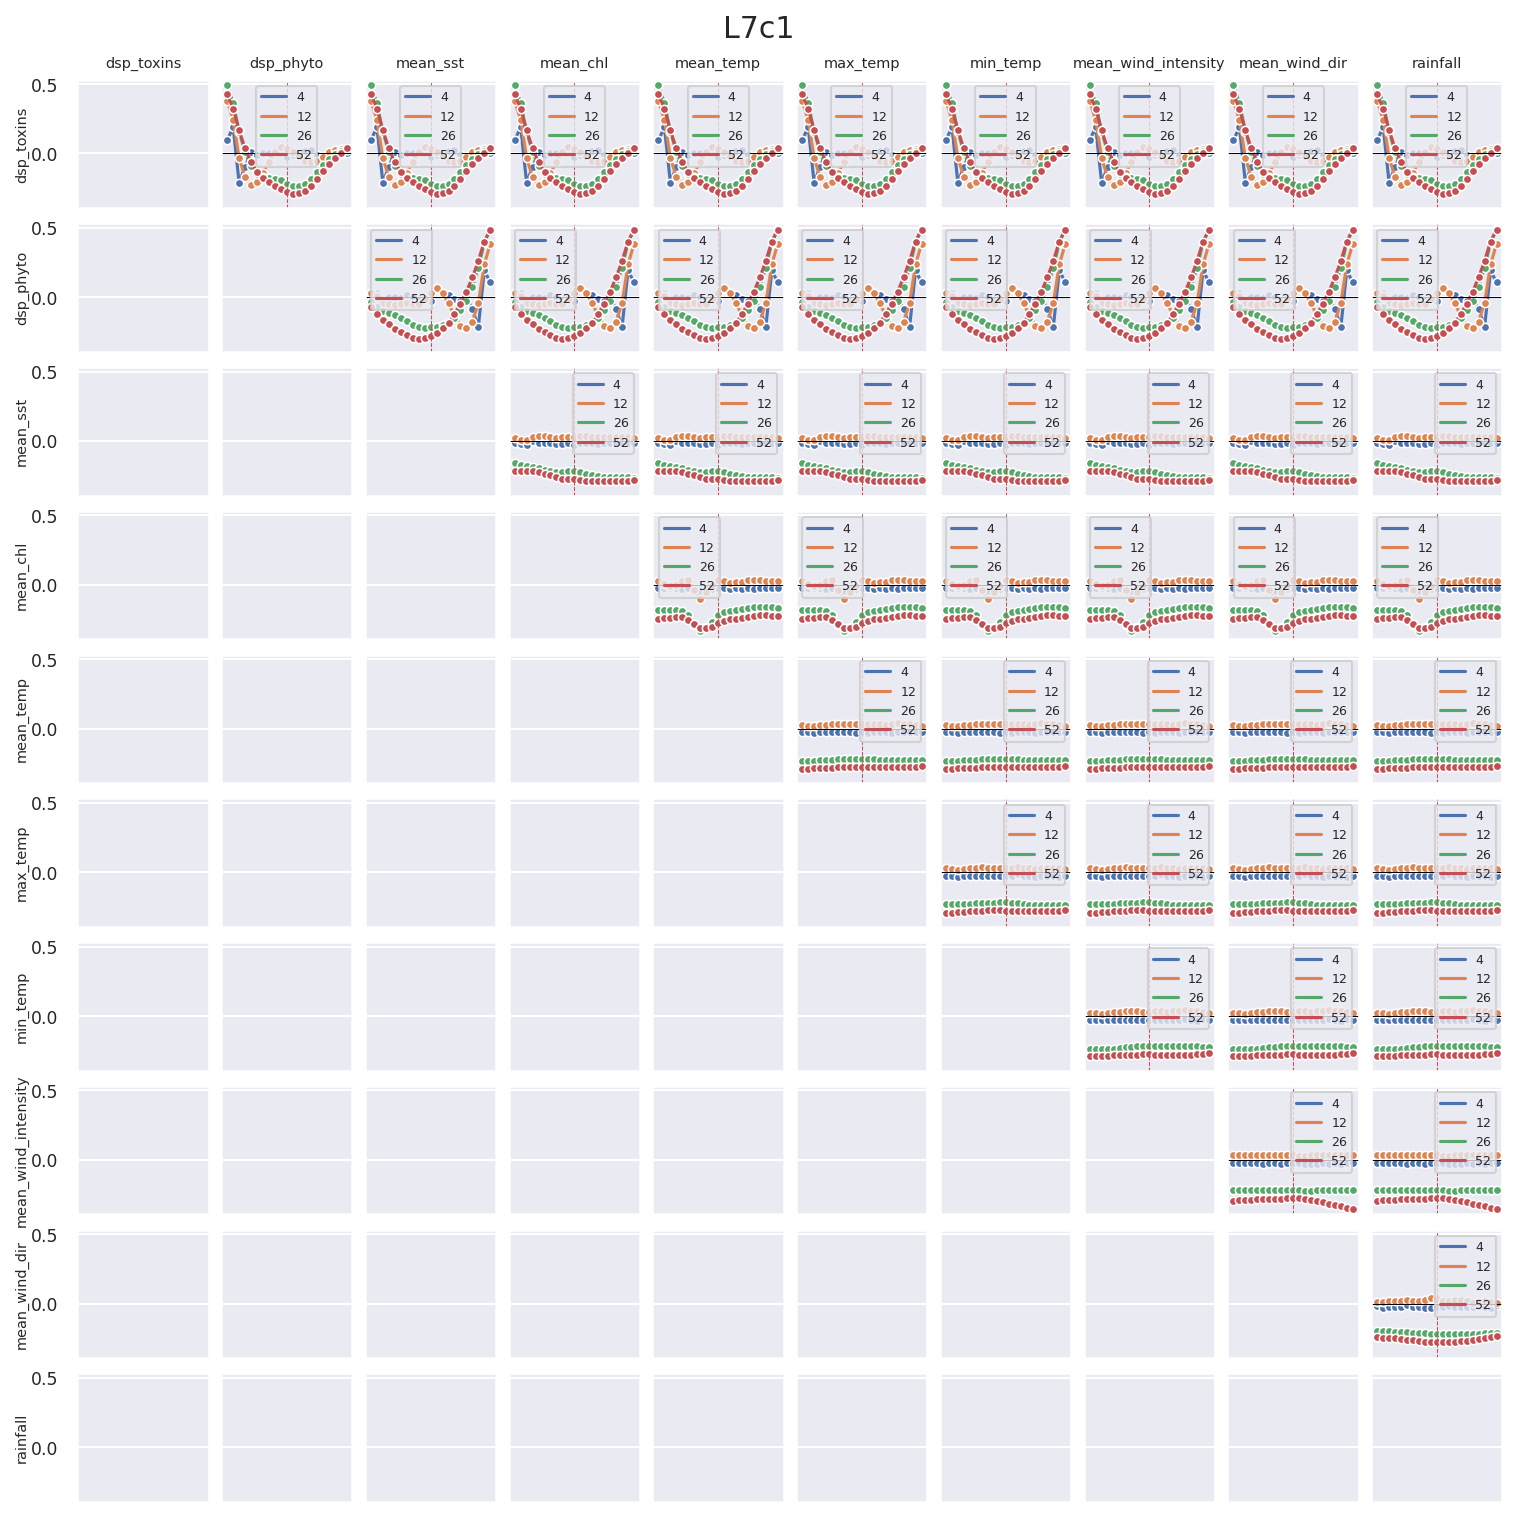

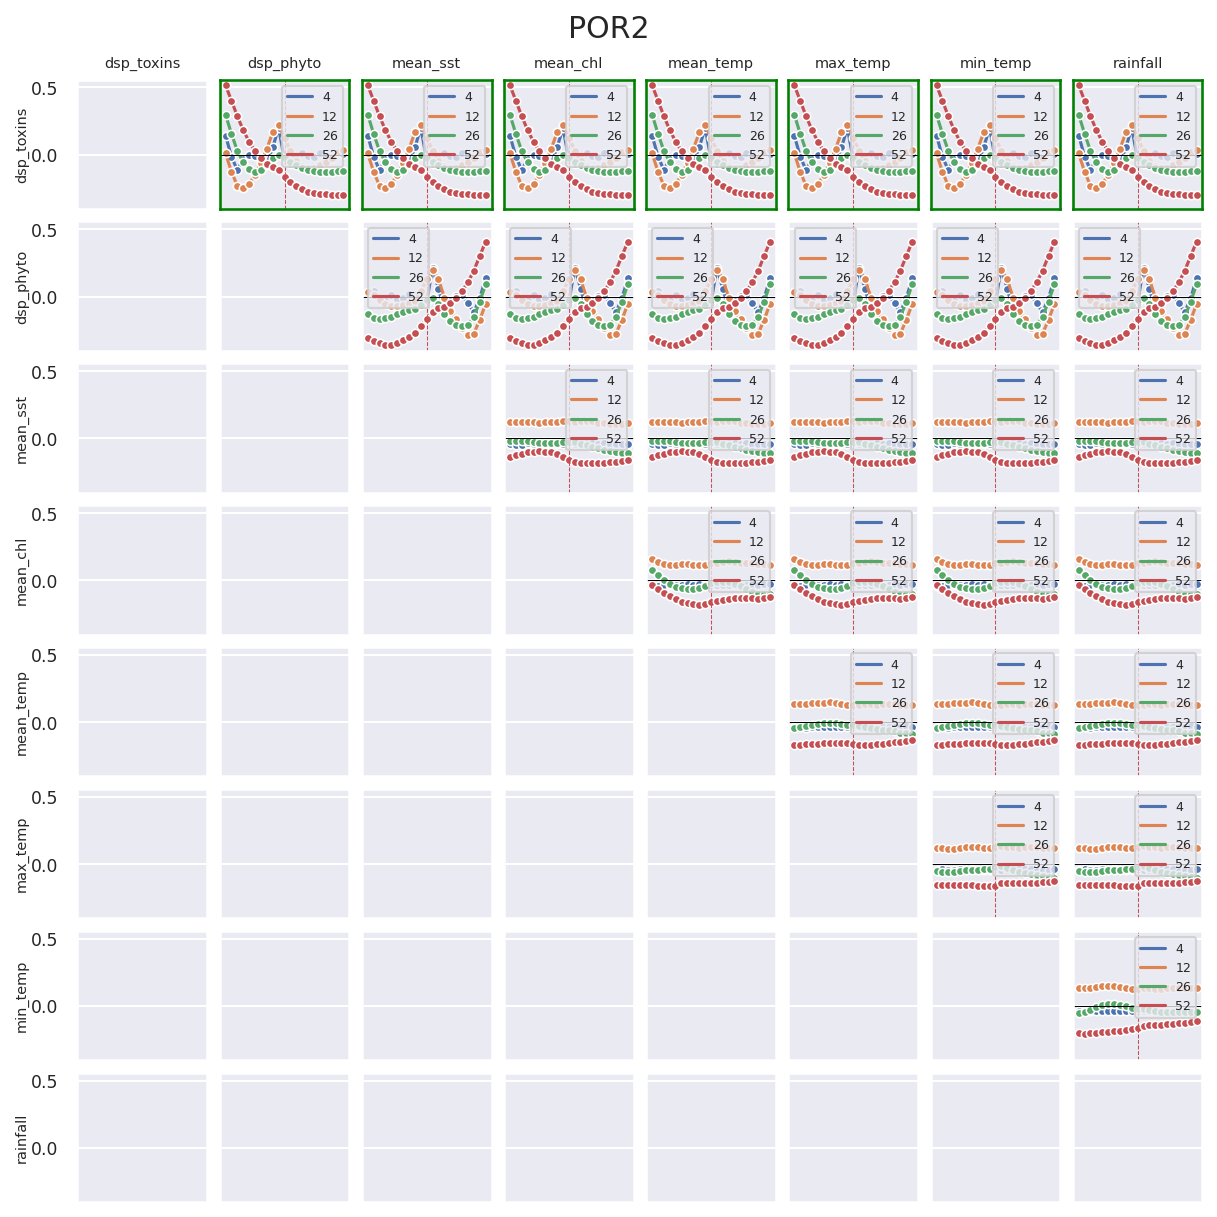

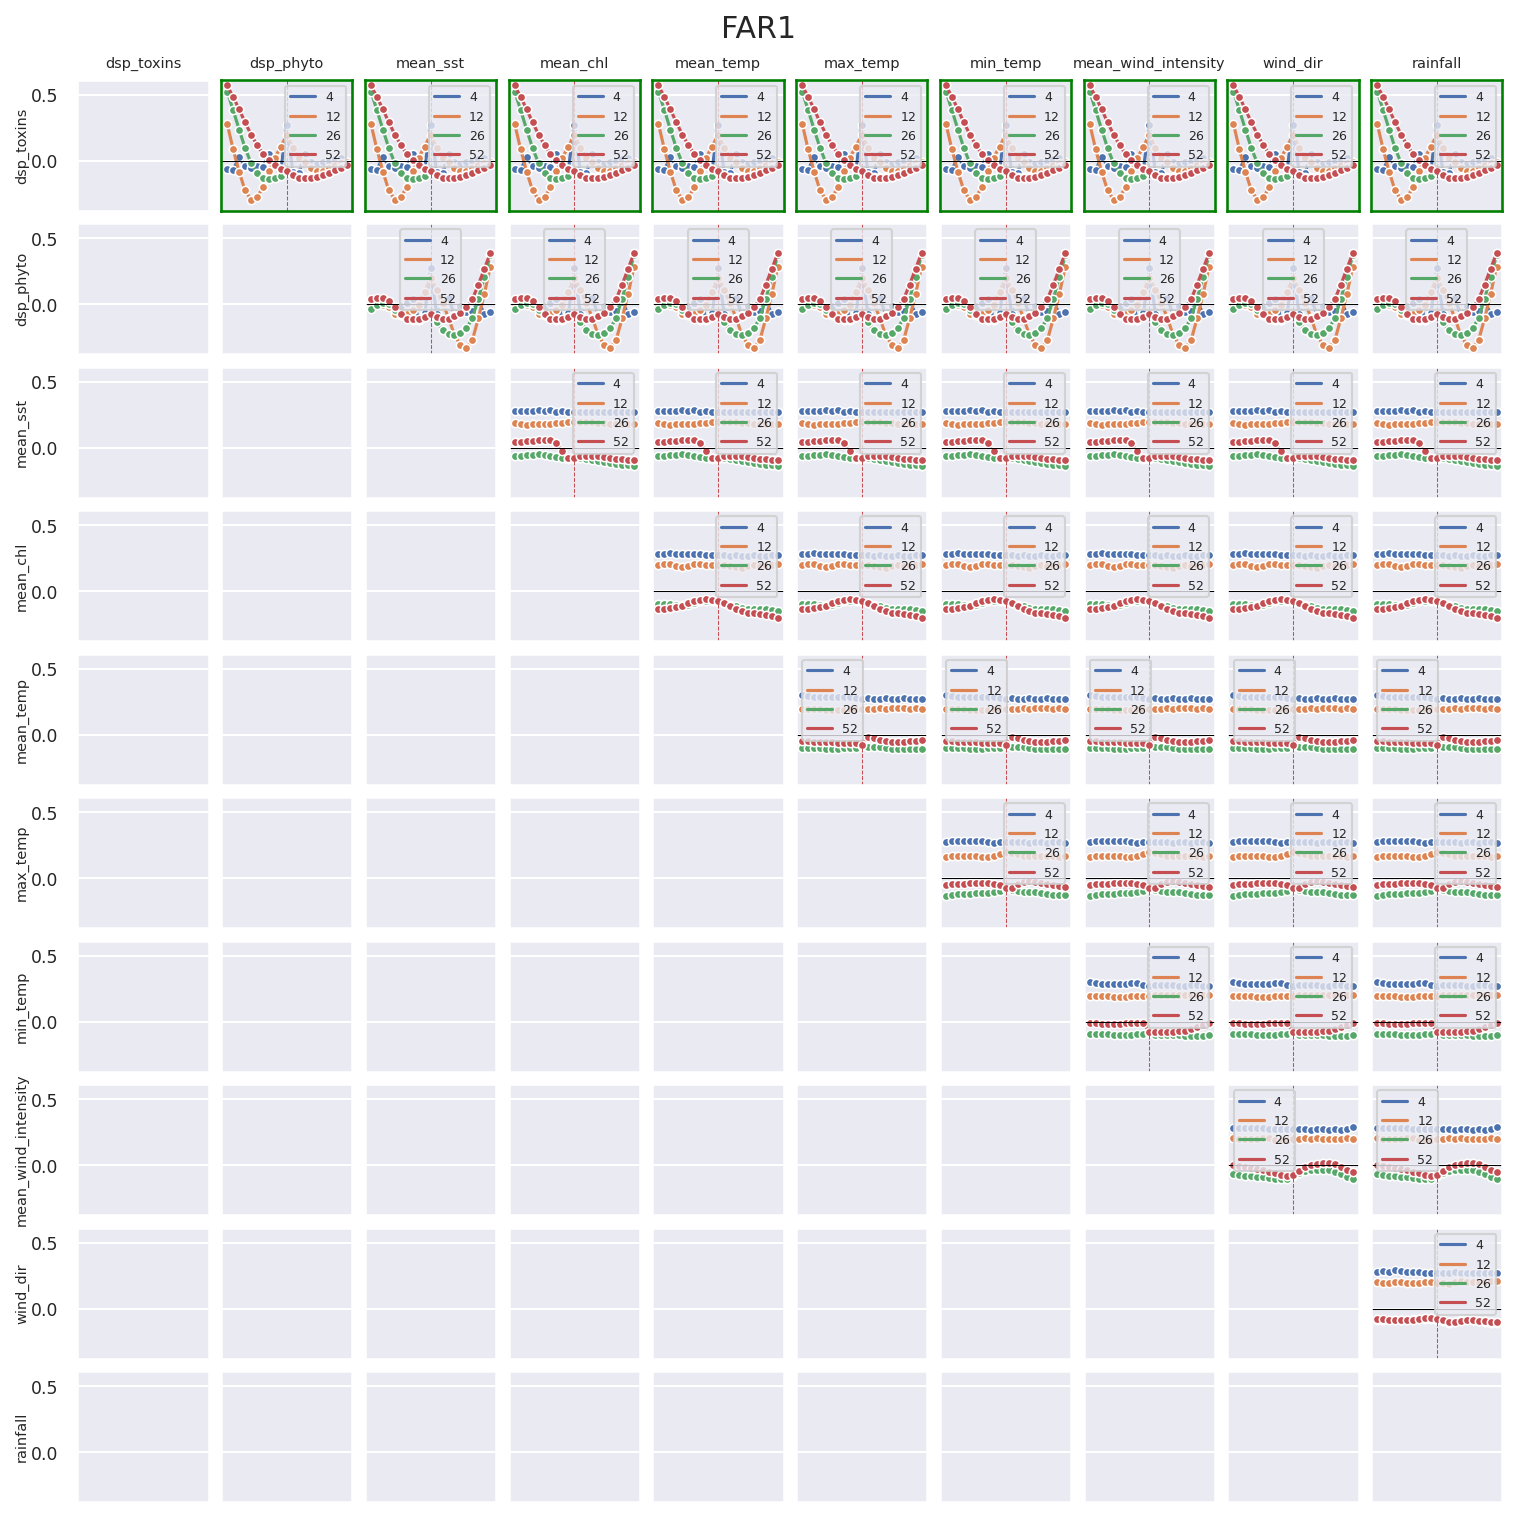

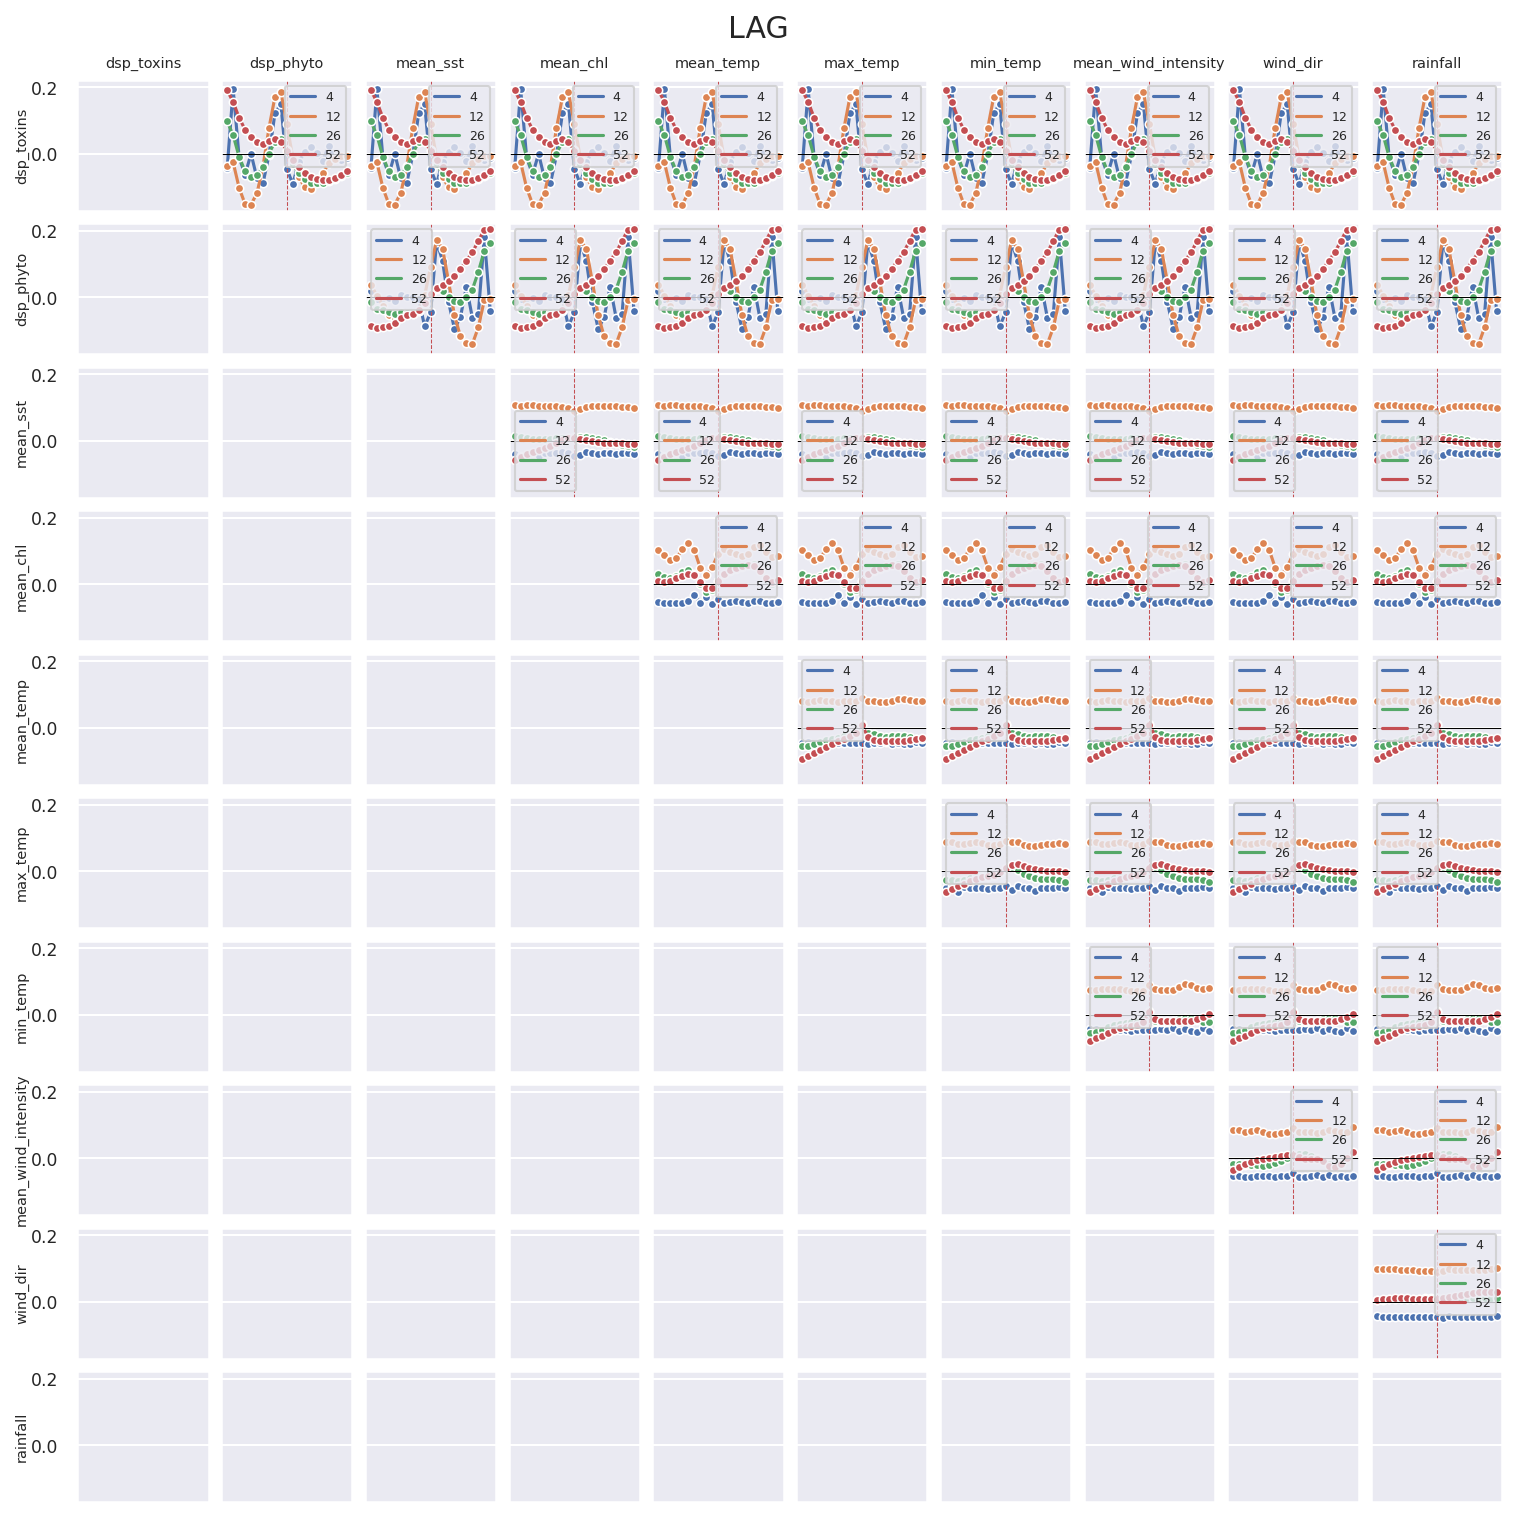

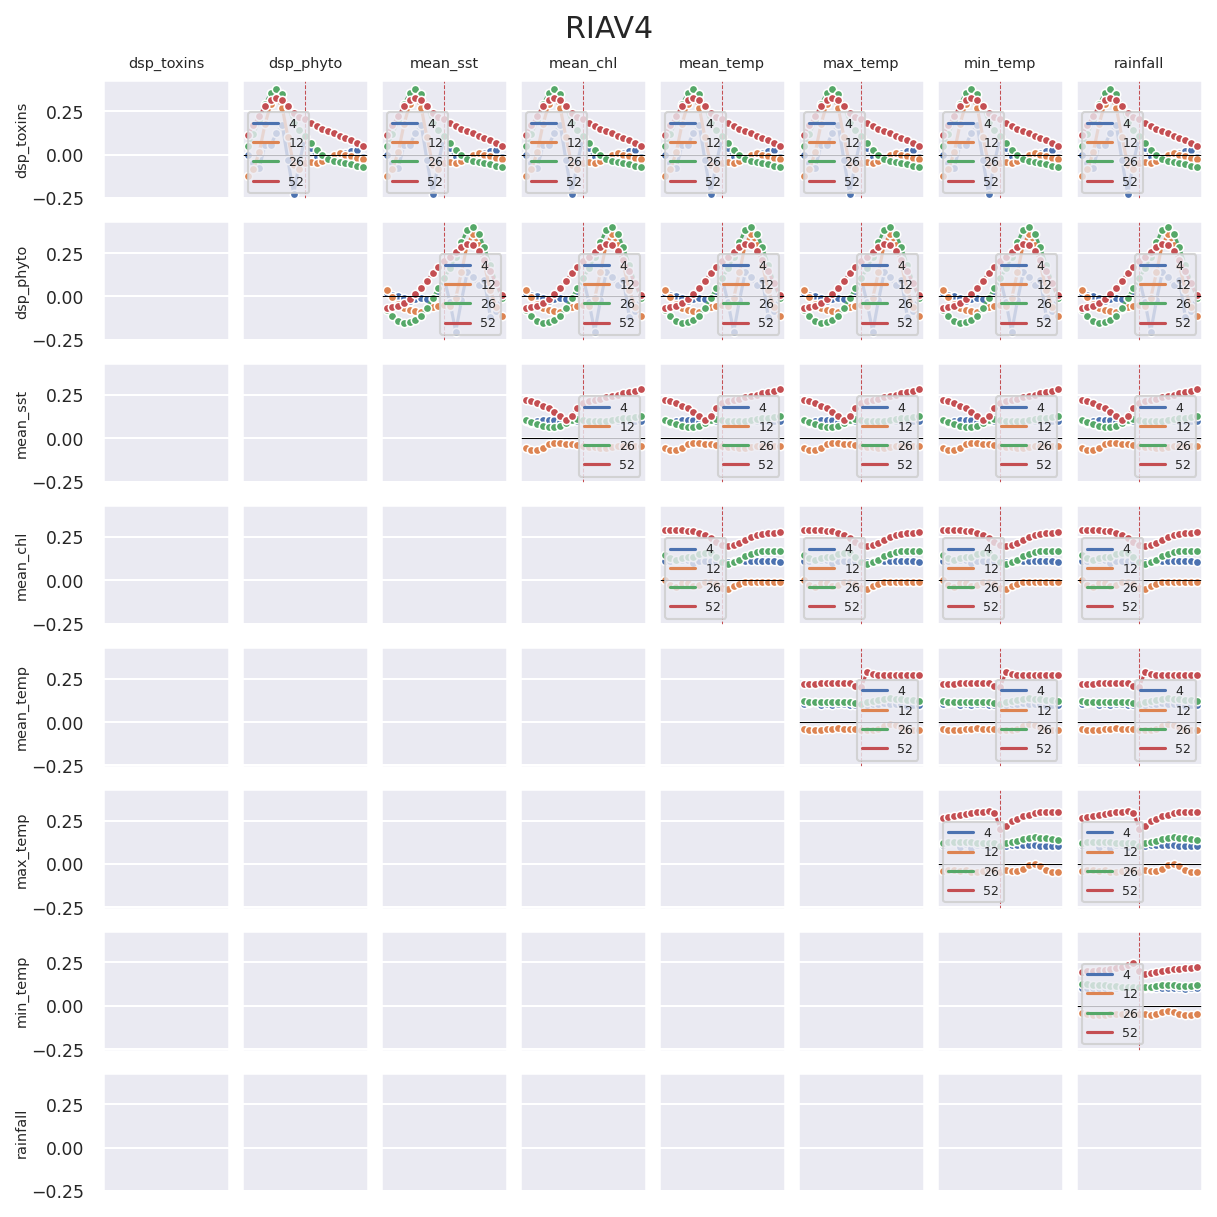

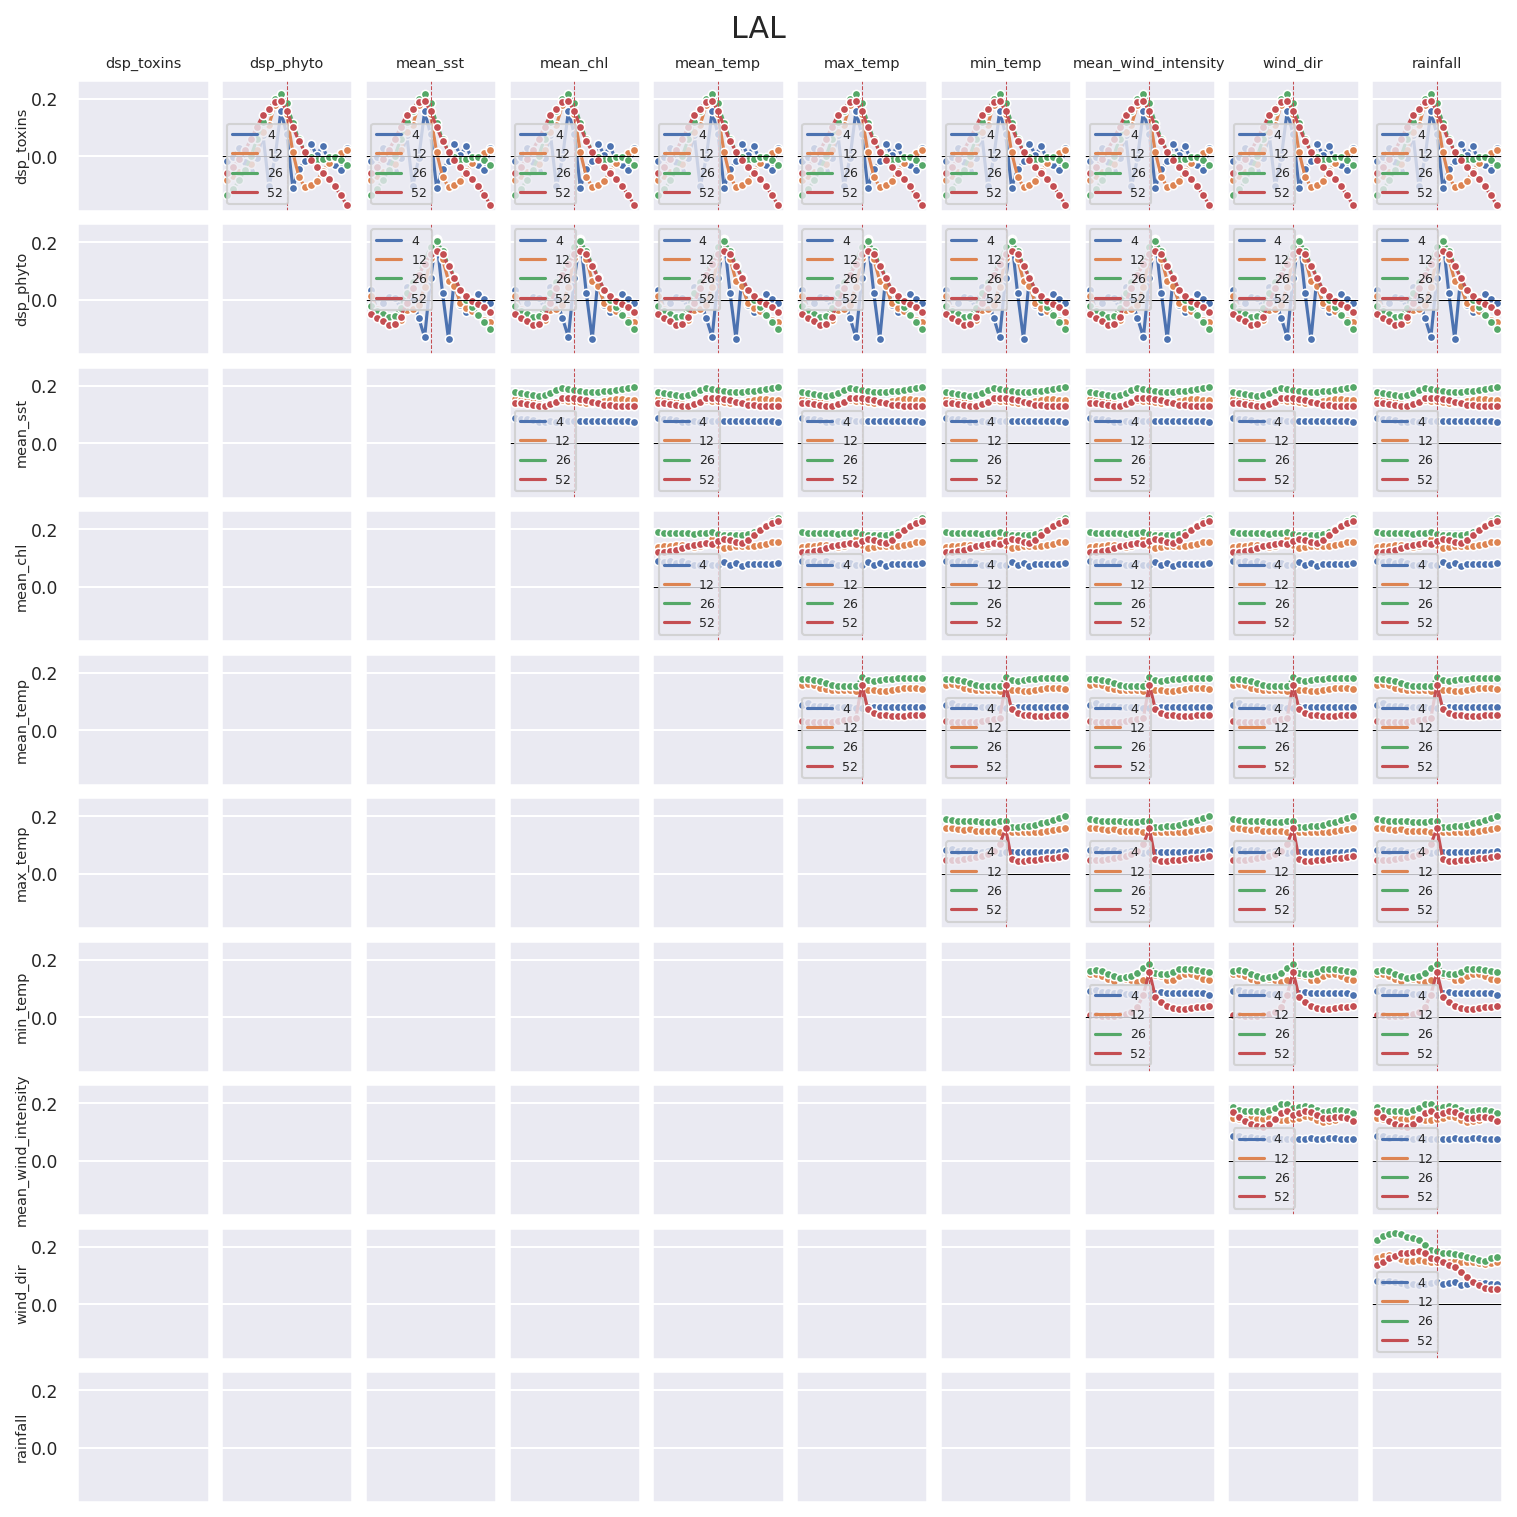

In [7]:
min_corr = 0.5
lags = np.arange(-10, 11, 1)

for area in dataframes:
    ts = dataframes[area]
    plot_dpcca_ipma(ts.copy(), min_corr, lags, area=area, k_range=[4, 12,26,52])